In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
# from read_fk_table import get_fk_table
from read_faserv_pdf import read_pdf
# from read_LHEF import read_LHEF_data
from data_errors import compute_errors
from MC_data_reps import generate_MC_replicas
from postfit_criteria import Postfit
from form_loss_fct import complete_loss_fct, raw_loss_fct
from postfit_measures import Measures
from logspace_grid import generate_grid
# from rebin_fk_data import rebin_fk

In [2]:
# Define global variables
num_obs = 1 #between 1 and 4
REPLICAS  = 10

#HYPERPARAMETERS
preproc = 1

fit_level = 1

max_counter = 100
max_Nepochs = 3500

In [4]:
import pandas as pd
# import torch
import torch.nn.functional


def get_fk_table(filename):
    """This function reads the fk table for the neutrino flux and pads them for computational efficiency later on

    Returns:
        tuple: x_alphas(grid points) and the fk table in tensor to fit torch
    """

    file_path = f"data_muon_sim_faser/{filename}.dat"
    df = pd.read_csv(file_path, sep="\s+", header=None)
    fk_table = df.to_numpy()

    x_alpha = fk_table[0, :]
    x_alpha = x_alpha.reshape(len(x_alpha), 1)

    # strip first row to get fk table
    fk_table = fk_table[1:, :]

    x_alpha = torch.tensor(x_alpha, dtype=torch.float32).view(-1, 1)
    fk_table = torch.tensor(fk_table, dtype=torch.float32)

    return x_alpha, fk_table

filename = "FK_Enu_7TeV_nu_W"
x_alphas, fk_tables_mu = get_fk_table(filename = filename)
filename = "FK_Enu_7TeV_nub_W"
x_alphas, fk_tables_mub = get_fk_table(filename = filename)

<>:16: SyntaxWarning: invalid escape sequence '\s'
<>:16: SyntaxWarning: invalid escape sequence '\s'
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80295/957887329.py:16: SyntaxWarning: invalid escape sequence '\s'
  df = pd.read_csv(file_path, sep="\s+", header=None)


In [5]:
# events = [50, 97, 71, 69, 48, 27]
# minev = [5.9, 4.3, 2.5, 2.2, 3.7,5.1]
events = [44.1, 92.7, 68.5, 66.8, 44.3, 21.9]
# events = [33.6, 59.5, 51.6, 84.1, 50.1, 19.6]
std_errev = [3.1,2.5,1.7,1.6,2.3,2.9]
# events, max_events, min_events, xvals_per_obs, binwidths, xlabels, events_per_obs, = read_LHEF_data()

sig_sys = std_errev
sig_stat = np.sqrt(events)
# binwidths = 100 * 65.6/150 
xlabels = ['mu']
data = np.array(events) 

# data, data_min, data_max, xvals_per_obs, binwidths, xlabels, events_per_obs = rebin_fk()
faser_bins_mu = [300, 600, 1000,1900]

faser_bins_mub = [300, 1000,1900]

xvals_per_obs_mu = [100,300,600,1000]
xvals_per_obs = [100,300,600,1000,-300,-100]
xvals_per_obs_mub = [-100,-300,-1000]


LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
sum
tensor([[ 78.2962],
        [102.2823],
        [ 88.8118],
        [ 85.0982]])
[4.05965792 2.52294793 2.96460897 2.91293732]
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
sum
tensor([[24.2189],
        [55.4814],
        [23.3481]])
[ 55.378647 126.86286   53.38733 ]
[44.1 92.7 68.5 66.8]


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80295/4031110511.py:5: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80295/4031110511.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)


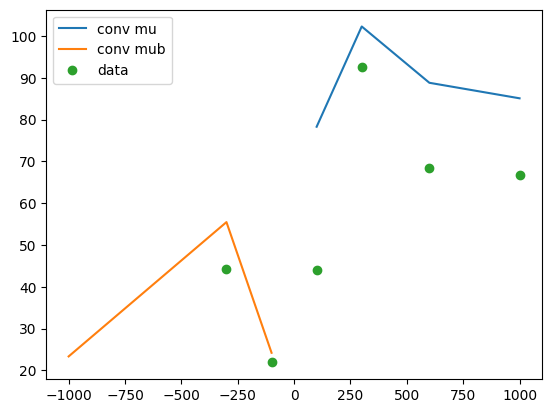

In [6]:
pdf = "FASERv_EPOS+POWHEG_7TeV"
binwidths_mu = [200,300,400,900]
binwidths_mu = torch.tensor(binwidths_mu, dtype=torch.float32).view(-1,1)
faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),14)
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)

conv = torch.matmul(fk_tables_mu,faser_pdf) * binwidths_mu
print('sum')
print((conv) * 65.6/150)
plt.plot(xvals_per_obs_mu,conv* 65.6/150,label='conv mu')
print(conv.detach().numpy().flatten()/data[:-2])
faser_pdf,x_faser = read_pdf(pdf,x_alphas.flatten(),-14)
faser_pdf = torch.tensor(faser_pdf, dtype=torch.float32).view(-1,1)


binwidths_mub = [200,700,900]
binwidths_mub = torch.tensor(binwidths_mub, dtype=torch.float32).view(-1,1)
conv = torch.matmul(fk_tables_mub,faser_pdf) * binwidths_mub 
print('sum')
print((conv) * 65.6/150)
plt.plot(xvals_per_obs_mub,conv* 65.6/150,label='conv mub')

plt.plot(xvals_per_obs,data ,'o',label='data')
plt.legend()
print(conv.detach().numpy().flatten())
print(data[:-2])

In [9]:
sig_sys = np.array(sig_sys)
# sig_sys = np.sqrt(np.diag(cov_matrix)) 
# sig_stat = 0
sig_stat = np.sqrt(data)
cov_matrix = np.diag(sig_sys**2+sig_stat**2)
# np.fill_diagonal(cov_matrix, sig_stat**2 + sig_sys**2)
cov_matrix = np.linalg.inv(cov_matrix)
cov_matrix = torch.tensor(cov_matrix, dtype=torch.float32, requires_grad=False)
#Generate MC replicas of data
level0,level1,level2 = generate_MC_replicas(REPLICAS,data,sig_sys,sig_stat)
# Get faserv pdf
# pdf = "faserv"
lowx = -8
n=250
x_vals = generate_grid(lowx,n)
faser_pdf,x_faser = read_pdf(pdf,x_vals,14)

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000


In [10]:
if fit_level ==0:
    pred = level0
if fit_level ==1:
    pred = level1
if fit_level ==2:
    pred = level2

[44.1 92.7 68.5 66.8 44.3 21.9]
[tensor([38.8686, 80.2145, 68.7590, 70.5419, 48.7836, 23.6490]), tensor([45.1344, 94.8957, 68.4817, 72.7751, 43.6796, 26.7608]), tensor([ 33.1139, 109.5042,  70.3632,  70.5272,  58.1161,  27.1224]), tensor([32.7054, 86.0276, 69.6017, 80.7578, 45.0849, 22.0711]), tensor([42.0086, 94.6909, 68.5716, 74.1385, 46.4637, 14.8544]), tensor([54.3282, 87.6131, 76.0825, 69.4054, 46.0658, 14.9688]), tensor([ 56.1439, 104.2705,  67.1518,  62.1778,  41.4009,  22.1271]), tensor([53.6912, 81.5071, 53.8540, 79.3158, 16.7637, 24.0917]), tensor([54.0496, 89.7203, 83.3179, 92.3519, 48.5408, 27.6736]), tensor([44.0495, 73.1331, 78.1967, 73.3196, 45.6167, 27.0275])]
[tensor([38.1774, 85.6378, 74.2933, 55.8721, 42.7681, 22.4672]), tensor([ 45.2209, 101.1137,  67.5104,  70.7443,  41.6938,  16.5632]), tensor([ 13.3012, 120.2712,  84.2443,  73.2907,  67.7335,  28.1891]), tensor([34.1358, 84.9759, 53.4566, 74.4931, 55.9706, 28.7760]), tensor([ 43.1950, 100.2147,  58.9728,  87.8008

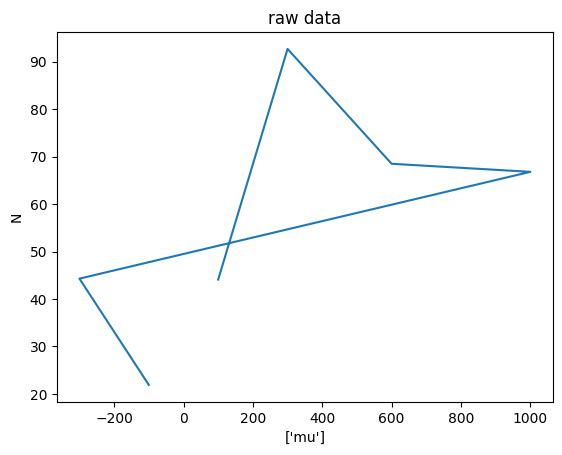

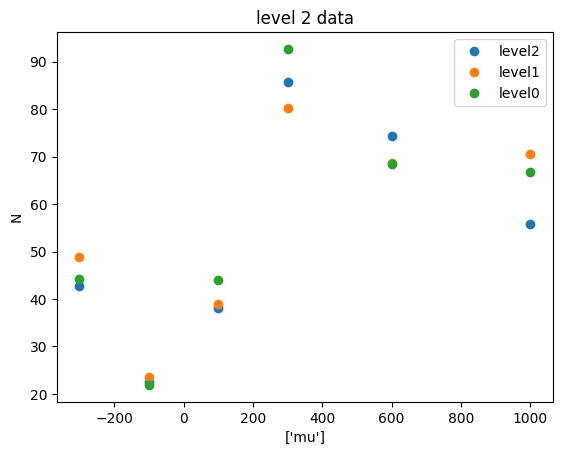

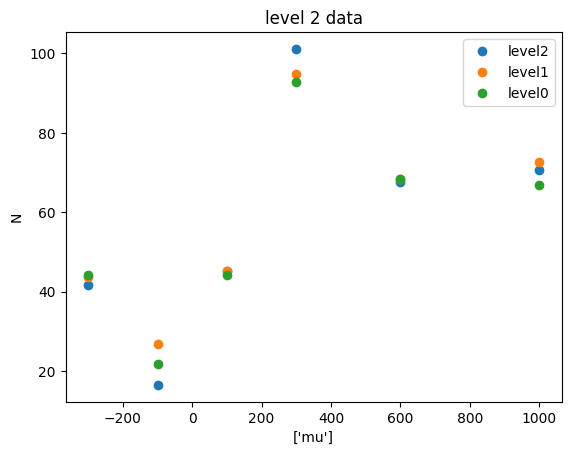

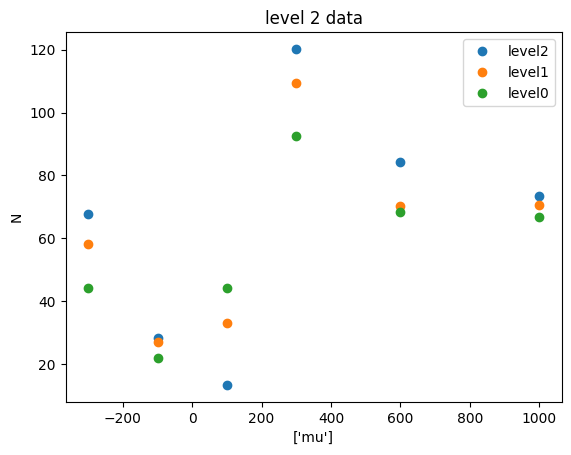

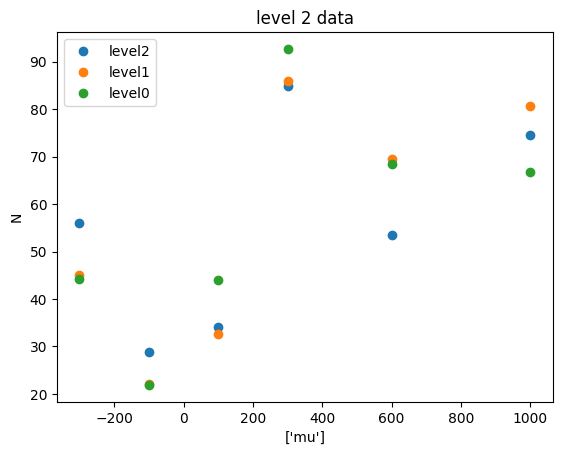

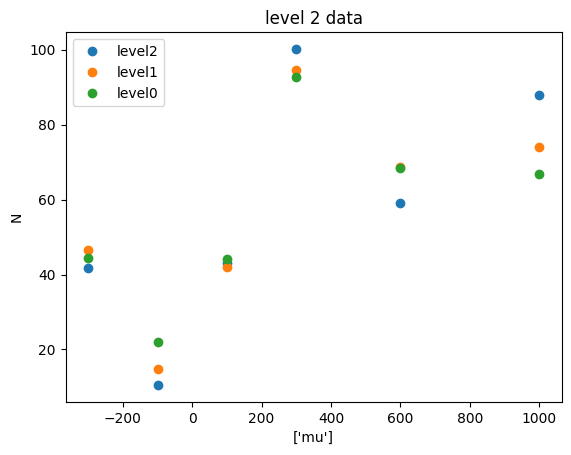

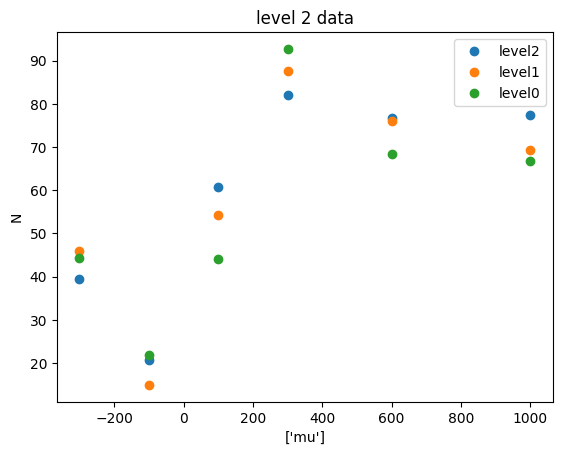

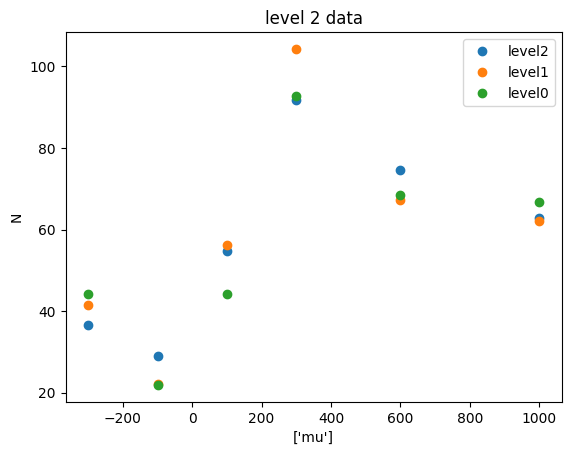

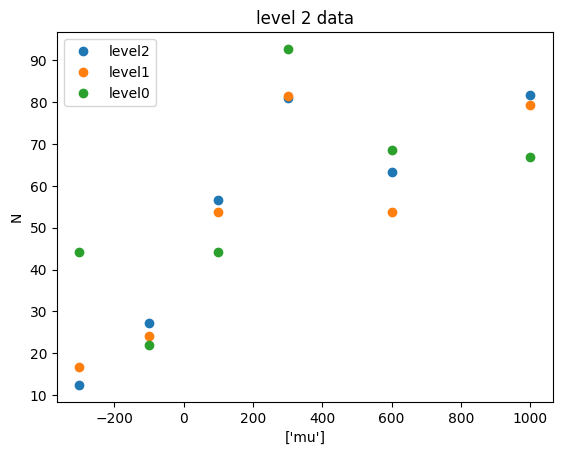

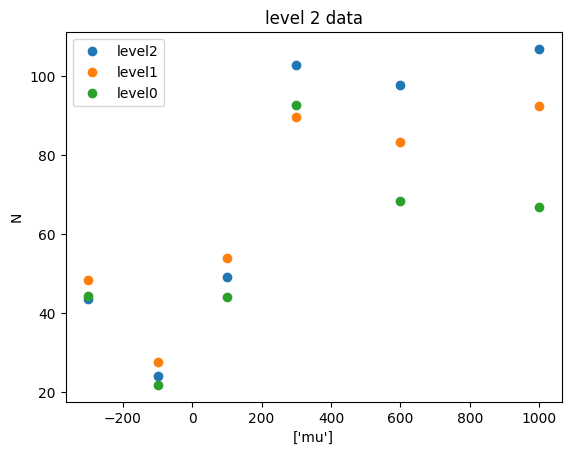

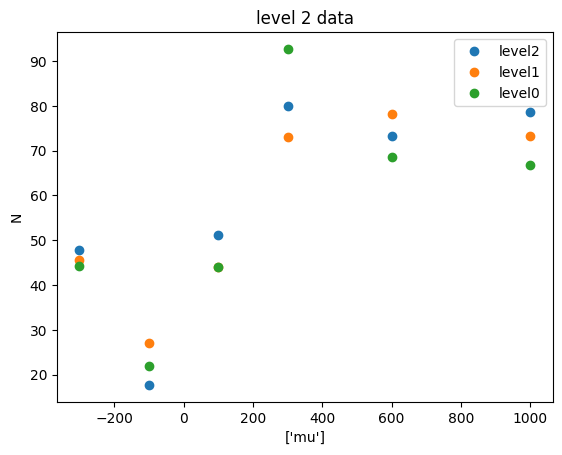

In [11]:
print(data)
print(level1)
print(level2)
plt.plot(xvals_per_obs,data)
plt.xlabel(xlabels)
plt.ylabel('N')
plt.title("raw data")
plt.show()

for i in range(REPLICAS):
    plt.plot(
        xvals_per_obs, level2[i], 'o',label="level2"
    )
    plt.plot(
        xvals_per_obs, level1[i], 'o',label="level1"
    )
    plt.plot(xvals_per_obs, data,'o',label="level0")
    plt.xlabel(xlabels)
    plt.legend()
    plt.ylabel("N")
    plt.title("level 2 data")
    plt.show()


In [12]:
l1 = 2
l2 = 2
l3 = 2
class SimplePerceptron(torch.nn.Module):
    def __init__(self, l1,l2,l3):
        super(SimplePerceptron, self).__init__()
        self.linear = torch.nn.Linear(1,l1)
        self.hidden = torch.nn.Linear(l1,2)
        self.hidden2 = torch.nn.Linear(l2,l3)
        self.hidden3 = torch.nn.Linear(l3,2)
        # self.relu = torch.nn.ReLU()
        # self.leakerelu = torch.nn.LeakyReLU(0.2)
        self.relu = torch.nn.Softplus()
        # self.leakerelu = torch.nn.Softplus(.7,100)
        self.leakerelu = torch.nn.Softplus()
        # self.leakerelu = torch.nn.Tanh()
        # self.leakerelu = torch.nn.ReLU()

    def forward(self, y):
        y = self.linear(y)
        y = self.relu(y)
        y = self.hidden(y) 
        y = self.leakerelu(y) 
        y = self.hidden2(y)
        y = self.leakerelu(y)
        y = self.hidden3(y)
        y = self.relu(y)
        # y = torch.nn.functional.softplus(y)
    
        return y

In [13]:
import torch.nn as nn

if preproc == 1:
    class CustomPreprocessing(nn.Module):
        def __init__(self, alpha,beta,gamma):
            super(CustomPreprocessing, self).__init__()

            self.alpha = nn.Parameter(torch.tensor(alpha, dtype=torch.float32, requires_grad=True))
            self.beta = nn.Parameter(torch.tensor(beta, dtype=torch.float32, requires_grad=True))
            self.gamma = nn.Parameter(torch.tensor(gamma, dtype=torch.float32, requires_grad=True))

            # self.register_buffer("alpha", torch.tensor(alpha, dtype=torch.float32))
            # self.register_buffer("beta", torch.tensor(beta, dtype=torch.float32))
            # self.register_buffer("gamma", torch.tensor(gamma, dtype=torch.float32))

        def forward(self, x):
            # alpha = (1 - 0.2)/2 *torch.tanh(self.alpha) + (1 + 0.2)/2
            # beta = (1.9 - 0.1)/2 *torch.tanh(self.alpha) + (1.9 + 0.1)/2
            # beta = abs(self.beta)
            # alpha = 1 - torch.nn.functional.softplus(self.alpha)
            # beta = torch.nn.functional.softmax(self.beta)
            x = torch.clamp(x, 1e-6, 1 - 1e-6)

            return self.gamma*(1 - x) ** self.beta * x**(1-self.alpha) 
            # return (1 - x) * x
            # return 10 * (1 - x)**2 * x**(1.5) 
            # return  self.gamma*(1 - x) ** self.beta * x**(1-self.alpha) 
        
    class PreprocessedMLP(nn.Module):
        def __init__(self, alpha, beta, gamma,l1, l2, l3):
            super(PreprocessedMLP, self).__init__()
            self.preprocessing = CustomPreprocessing(alpha, beta,gamma)
            self.mlp = SimplePerceptron(l1, l2, l3)

        def forward(self, x):
            f_preproc = self.preprocessing(x)
            f_NN = self.mlp(x)
            f_nu = f_preproc * f_NN
            # return f_NN
            # return f_NN- self.mlp(torch.tensor([1.], dtype=torch.float32).view(-1,1)) 
            return f_nu
        
        def neuralnet(self, x):
            f_NN = self.mlp(x)
            return f_NN
        
        def preproc(self, x):
            f_preproc = self.preprocessing(x)
            return f_preproc
        


In [14]:
class CustomLoss(nn.Module):
    def __init__(self):
        super(CustomLoss,self).__init__()

    def forward(self,pred,
    data,
    cov_matrix,small_x_point1,small_x_point2,model):
        loss = raw_loss_fct(pred,
    data,
    cov_matrix,small_x_point1,small_x_point2,model)
        return loss

In [15]:
#Define variables for fit
# x_alpha_more_bins = np.logspace(-5,0,250)
# x_alpha_more_bins = torch.tensor(x_alpha_more_bins, dtype=torch.float32).view(-1,1)
lowx = -10
n=500
x_vals = generate_grid(lowx,n)
x_vals = torch.tensor(x_vals, dtype=torch.float32).view(-1,1)
neutrino_pdfs_mu,neutrino_pdfs_mub,N_event_pred, arc_lenghts, chi_squares, int_penaltys,pos_penaltys, preproc_pdfs, nn_pdfs  = [],[],[],[],[],[],[],[],[]
x_alphas = x_alphas.clone().detach().requires_grad_(True)

In [16]:
# x_alphas *=2
lr=0.01

def perform_fit(pred,REPLICAS):
    
    
    for i in range(REPLICAS):
        
        if preproc == 1:
            alpha,beta,gamma = np.random.uniform(-5,1), np.random.uniform(-20,20), np.random.uniform(0,100),
            model = PreprocessedMLP(alpha, beta, gamma,l1, l2, l3)
        
            
                # model.load_state_dict(model_params)    

        criterion = CustomLoss()
        # criterion = torch.nn.MSELoss()
        # optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-3)
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)
        # optimizer = torch.optim.SGD(model.parameters(), lr=0.1, momentum=0.3)
        

        # optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        losses = []
        pred[i] = pred[i].squeeze()
        model.train()
        best_loss = 1e13 # initial loss
        counter = 0
        num_epochs = 12000
        # num_epochs = 0
        # for ep in range(num_epochs):
        while counter < max_counter:  
            # if num_epochs>max_Nepochs:
            #     break
            
            # num_epochs+=1
            optimizer.zero_grad()
            y_pred =  model(x_alphas) 
            # y_pred =  model(x_alphas) * x_alphas
            # y_pred_mu = torch.matmul(fk_tables_mu,y_pred[:,0]- model(torch.tensor([1.], dtype=torch.float32).view(-1,1))[:,0]  )  * binwidths_mu.flatten() 
            # y_pred_mub = torch.matmul(fk_tables_mub,y_pred[:,1]- model(torch.tensor([1.], dtype=torch.float32).view(-1,1))[:,1]  )  * binwidths_mub.flatten() 
            y_pred_mu = torch.matmul(fk_tables_mu,y_pred[:,0] )  * binwidths_mu.flatten() 
            y_pred_mub = torch.matmul(fk_tables_mub,y_pred[:,1]  )  * binwidths_mub.flatten()  

            y_pred_mu = y_pred_mu.squeeze()
            y_pred_mub = y_pred_mub.squeeze()

            y_pred_mu[-1] = y_pred_mu[-1] + y_pred_mub[-1]
            
            y_pred_mub = y_pred_mub[:-1]

            y_pred_mub = torch.flip(y_pred_mub, dims=[0])
            
            y_preds = torch.hstack((y_pred_mu, y_pred_mub))

            # last_point = model(torch.tensor([5*0.1], dtype=torch.float32).view(-1,1))
            x_int = torch.tensor([1e-4,1.], dtype=torch.float32).view(-1,1)
            y_int_mu = model(x_int)[:,0]
            y_int_mub = model(x_int)[:,1]
            # small_x_point2 = model(torch.tensor([.4], dtype=torch.float32).view(-1,1))[:,0]
            small_x_point2 = model(torch.tensor([6*10**-4], dtype=torch.float32).view(-1,1))[:,1]
            large_x_point= model(torch.tensor([1.], dtype=torch.float32).view(-1,1))[:,0]
            # smoothness_penalty = model(torch.tensor([.3], dtype=torch.float32).view(-1,1))[:,0]

            loss = criterion(y_preds, pred[i],cov_matrix,y_int_mu,y_int_mub,x_int)
            
            loss.backward()
            print(loss)
    
            losses.append(loss.detach().numpy())
            optimizer.step()
            
            # if ep % 100 == 0:
            #     print(loss.detach().numpy())   
            if abs(loss) <1 :
                break
            if loss < best_loss:
                best_loss = loss
                counter = 0
            else:
                counter +=1   

        if loss < 5.:    
            # print(y_preds[5])

            print(f"reduced chi^2 level 2 = {loss}")
            # print(f"reduced chi^2 level 1 = {red_chi_square_level1}")
            print(f"Constrained alpha: {(model.preprocessing.alpha.item())}")
            print(f"Constrained beta: {(model.preprocessing.beta.item())}")
            print(f"Constrained gamma: {model.preprocessing.gamma.item()}") 

            # save outcome of fit and its measures for postfit selection criteria
            chi_squares.append(loss.detach().numpy())
            # preproc_pdf = ((1 - x_alpha_more_bins) ** (beta) * x_alpha_more_bins ** (1-alpha)).detach().numpy().flatten()
            f_nu_mub = model(x_vals)[:,1].detach().numpy().flatten() 
            f_nu_mu = model(x_vals)[:,0].detach().numpy().flatten() 
            
            # print(preproc_pdf.shape)

            preproc_pdf = model.preproc(x_vals).detach().numpy().flatten()
            preproc_pdfs.append(model.preproc(x_vals).detach().numpy().flatten())
            nn_pdf  = model.neuralnet(x_vals)[:,0].detach().numpy().flatten()
            nn_pdfs.append(nn_pdf)

            N_event_pred.append(y_preds.detach().numpy())
            

            print(xvals_per_obs)
            xvals_per_obsa = np.array(xvals_per_obs)
            sorted_indices = np.argsort(xvals_per_obsa)
            sorted_x_vals = xvals_per_obsa[sorted_indices]
            sorted_y_vals = y_preds.detach().numpy().flatten()[sorted_indices]
            sorted_preds = pred[i][sorted_indices]
            sorted_level0= level0[i][sorted_indices]
            plt.plot(sorted_x_vals,sorted_y_vals,label = 'nn')
            plt.plot(sorted_x_vals,sorted_preds,label = 'level1')
            plt.plot(sorted_x_vals,sorted_level0,label = 'level0')
            plt.legend()
            plt.show()

            plt.plot(x_vals,f_nu_mu,label='mu')
            plt.plot(x_vals,preproc_pdf,label='preproc')
            plt.plot(x_vals,nn_pdf,label='nn')
            # plt.plot(x_vals,f_nu_mub,label='mub')
            plt.xscale('log')
            plt.yscale('log')
            plt.ylim(10**-3,10**4)
            plt.legend()
            plt.show()
            # cont_pred = model(x_alpha_more_bins).detach().numpy().flatten()
            neutrino_pdfs_mu.append(f_nu_mu)
            neutrino_pdfs_mub.append(f_nu_mub)
            plt.yscale('log')
            print(f'counter = {counter}')
            plt.plot(range(1, len(losses) + 1), losses)
            plt.xlabel('#epochs')
            plt.ylabel('loss')
            plt.title('level 0 closure test, no preprocessing')
            plt.show()
            # plt.plot(x_alpha_more_bins,preproc_pdf)
            # plt.xscale('log')
            # plt.yscale('log')
            # plt.show()
    # return arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model
    return chi_squares,N_event_pred, neutrino_pdfs_mu,neutrino_pdfs_mub,model

tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBack

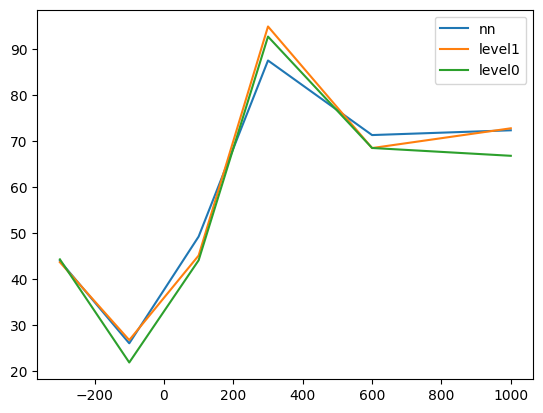

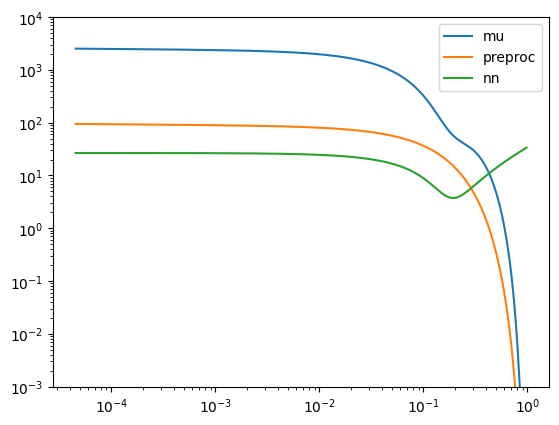

counter = 0


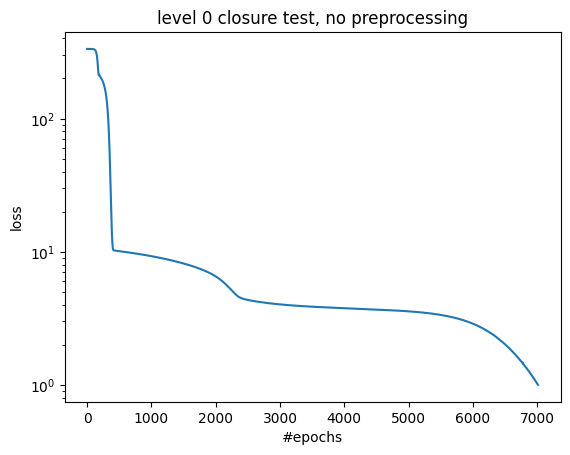

tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBack

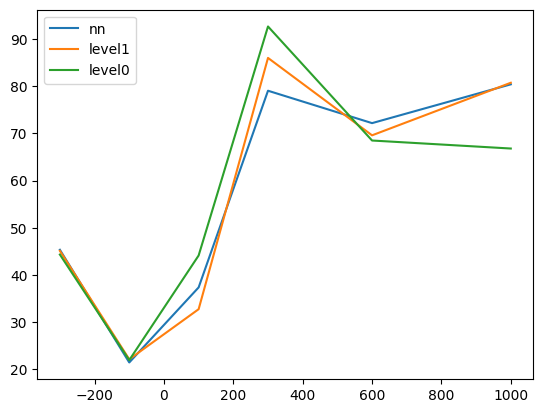

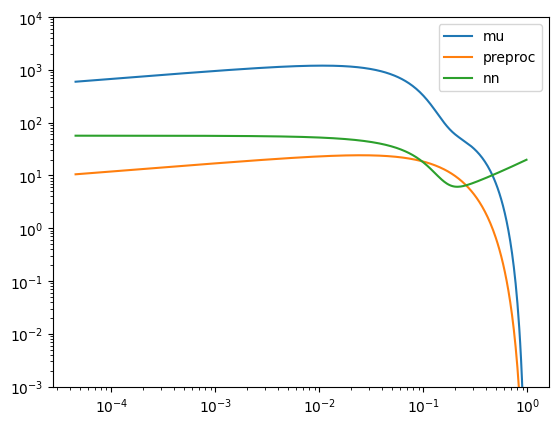

counter = 0


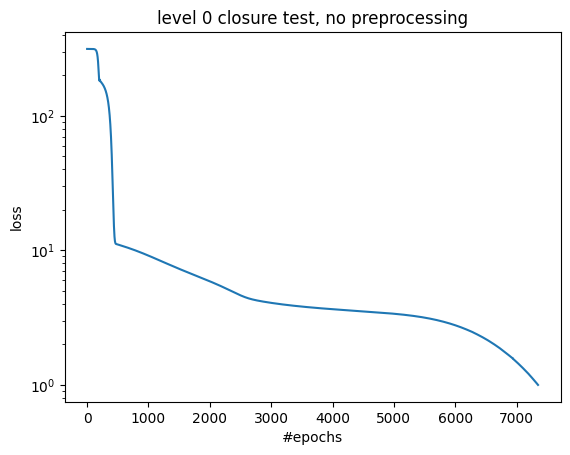

tensor(319.3964, grad_fn=<AddBackward0>)
tensor(319.3964, grad_fn=<AddBackward0>)
tensor(319.3963, grad_fn=<AddBackward0>)
tensor(319.3963, grad_fn=<AddBackward0>)
tensor(319.3963, grad_fn=<AddBackward0>)
tensor(319.3963, grad_fn=<AddBackward0>)
tensor(319.3963, grad_fn=<AddBackward0>)
tensor(319.3963, grad_fn=<AddBackward0>)
tensor(319.3963, grad_fn=<AddBackward0>)
tensor(319.3963, grad_fn=<AddBackward0>)
tensor(319.3962, grad_fn=<AddBackward0>)
tensor(319.3962, grad_fn=<AddBackward0>)
tensor(319.3962, grad_fn=<AddBackward0>)
tensor(319.3962, grad_fn=<AddBackward0>)
tensor(319.3962, grad_fn=<AddBackward0>)
tensor(319.3962, grad_fn=<AddBackward0>)
tensor(319.3962, grad_fn=<AddBackward0>)
tensor(319.3961, grad_fn=<AddBackward0>)
tensor(319.3961, grad_fn=<AddBackward0>)
tensor(319.3961, grad_fn=<AddBackward0>)
tensor(319.3961, grad_fn=<AddBackward0>)
tensor(319.3961, grad_fn=<AddBackward0>)
tensor(319.3961, grad_fn=<AddBackward0>)
tensor(319.3960, grad_fn=<AddBackward0>)
tensor(319.3960,

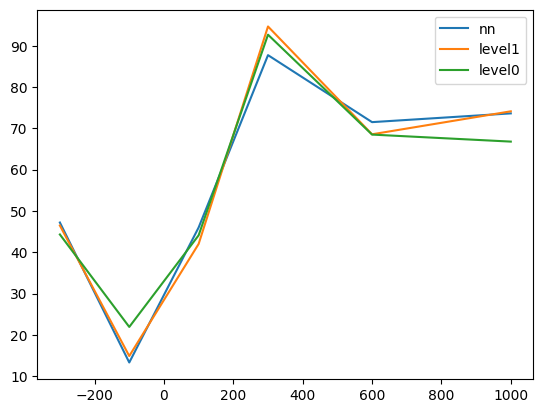

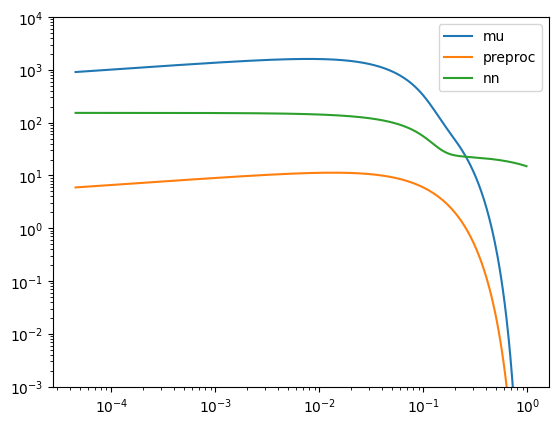

counter = 0


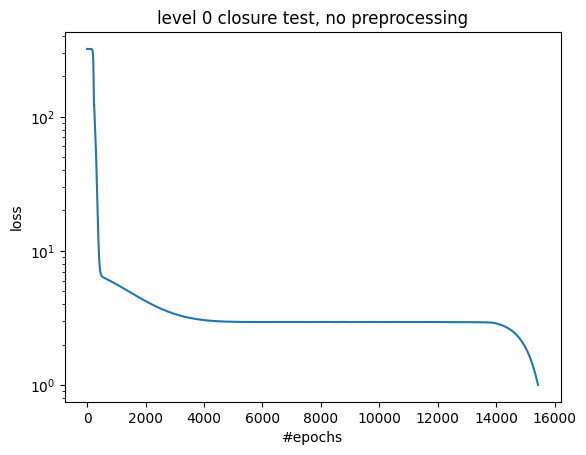

tensor(332.2334, grad_fn=<AddBackward0>)
tensor(332.1954, grad_fn=<AddBackward0>)
tensor(332.1558, grad_fn=<AddBackward0>)
tensor(332.1147, grad_fn=<AddBackward0>)
tensor(332.0719, grad_fn=<AddBackward0>)
tensor(332.0273, grad_fn=<AddBackward0>)
tensor(331.9809, grad_fn=<AddBackward0>)
tensor(331.9325, grad_fn=<AddBackward0>)
tensor(331.8820, grad_fn=<AddBackward0>)
tensor(331.8293, grad_fn=<AddBackward0>)
tensor(331.7744, grad_fn=<AddBackward0>)
tensor(331.7169, grad_fn=<AddBackward0>)
tensor(331.6567, grad_fn=<AddBackward0>)
tensor(331.5939, grad_fn=<AddBackward0>)
tensor(331.5281, grad_fn=<AddBackward0>)
tensor(331.4592, grad_fn=<AddBackward0>)
tensor(331.3870, grad_fn=<AddBackward0>)
tensor(331.3113, grad_fn=<AddBackward0>)
tensor(331.2319, grad_fn=<AddBackward0>)
tensor(331.1486, grad_fn=<AddBackward0>)
tensor(331.0612, grad_fn=<AddBackward0>)
tensor(330.9693, grad_fn=<AddBackward0>)
tensor(330.8727, grad_fn=<AddBackward0>)
tensor(330.7712, grad_fn=<AddBackward0>)
tensor(330.6645,

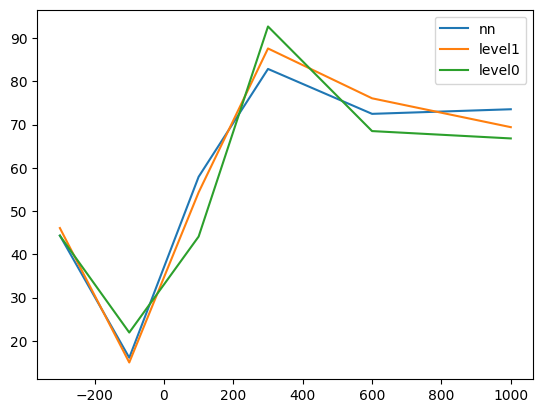

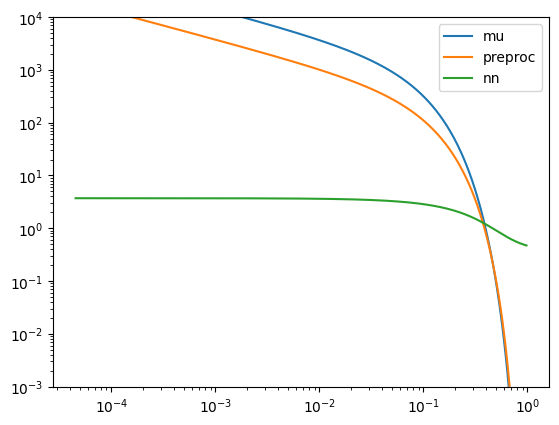

counter = 0


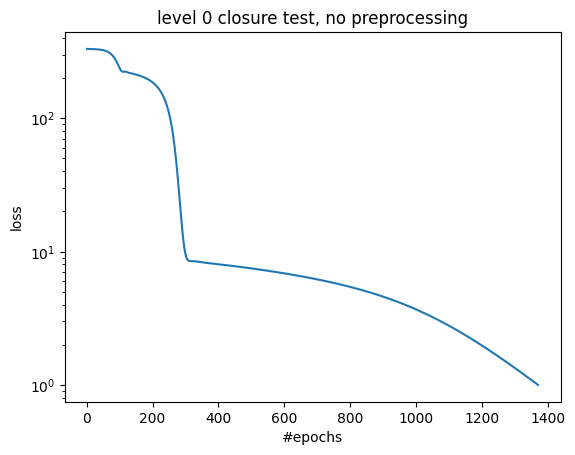

tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBack

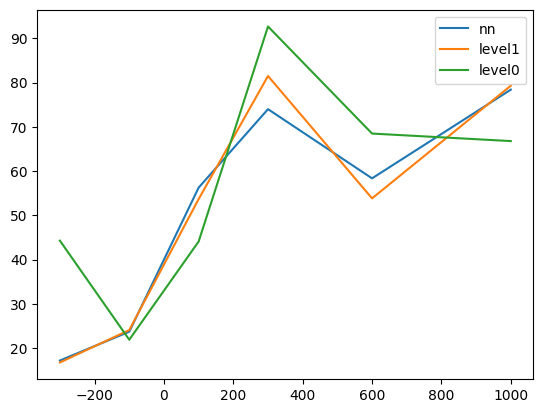

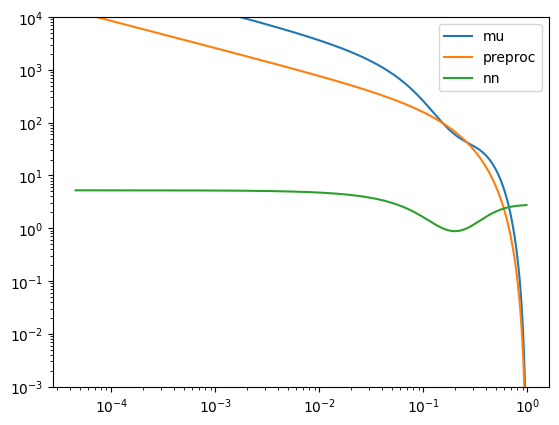

counter = 0


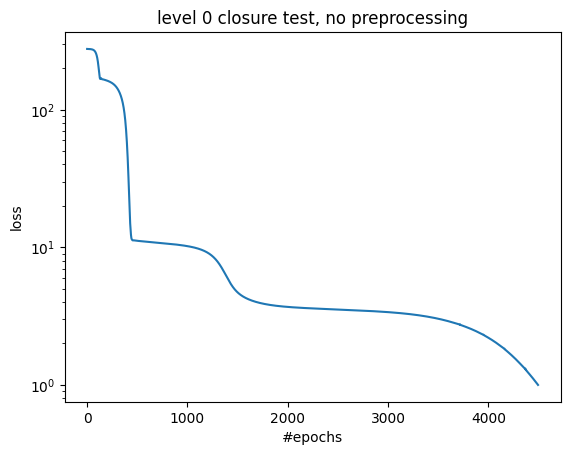

tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBackward0>)
tensor(nan, grad_fn=<AddBack

In [17]:
chi_squares,N_event_pred, neutrino_pdfs_mu,neutrino_pdfs_mub,model = perform_fit(pred,REPLICAS)

In [18]:
closure_fit = Postfit()
# neutrino_pdfs, N_event_pred = closure_fit.apply_postfit_criteria(chi_squares,N_event_pred,neutrino_pdfs)

In [19]:
x_vals = x_vals.detach().numpy().flatten()
faser_pdf_mu,x_faser = read_pdf(pdf,x_vals,14) 
faser_pdf_mub,x_faser = read_pdf(pdf,x_vals,-14)
# mean_fnu = np.mean(neutrino_pdfs,axis=0) *x_vals
mean_fnu_mu = np.mean(neutrino_pdfs_mu,axis=0) 
mean_fnu_mub = np.mean(neutrino_pdfs_mub,axis=0) 

mean_pdf_preproc = np.mean(preproc_pdfs,axis=0) 
mean_nn_pdf = np.mean(nn_pdfs,axis=0) 

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000


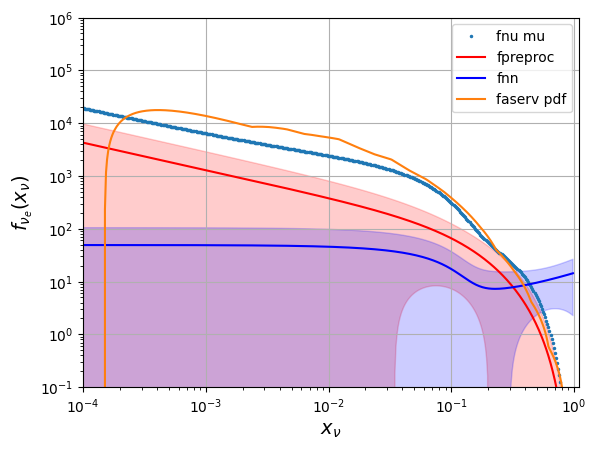

In [22]:
# plt.plot(cont_x,mean_pdf_preproc*mean_nn_pdf*(x_alpha_more_bins.detach().numpy().flatten()),label = 'mult' )
plt.plot(x_vals,mean_fnu_mu,'o',label="fnu mu",markersize=1.5)

sig_nn_pdf = np.std(nn_pdfs,axis = 0)
sig_pre_pdf= np.std(preproc_pdfs,axis = 0)
plt.plot(x_vals,mean_pdf_preproc,label="fpreproc",markersize=1.5,color = 'red')
plt.fill_between(x_vals, (mean_pdf_preproc+sig_pre_pdf), (mean_pdf_preproc-sig_pre_pdf), alpha=0.2,color = 'red')

plt.plot(x_vals,mean_nn_pdf,label="fnn",markersize=1.5,color = 'blue')
plt.fill_between(x_vals, (mean_nn_pdf+sig_nn_pdf), (mean_nn_pdf-sig_nn_pdf), alpha=0.2,color = 'blue')
# plt.axvline(x=min(xvals_per_obs[0])/14000, color='green', linestyle='--', label='no data to the left of this line')
plt.plot(x_faser,faser_pdf_mu*65.6/150,label ='faserv pdf')
plt.xlabel(r"$x_{\nu}$",fontsize = 14)
plt.ylabel(r"$f_{\nu_e}(x_{\nu})$",fontsize = 14)
plt.ylim(10**-1,10**6)
plt.xlim(10**-4,1.1)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()


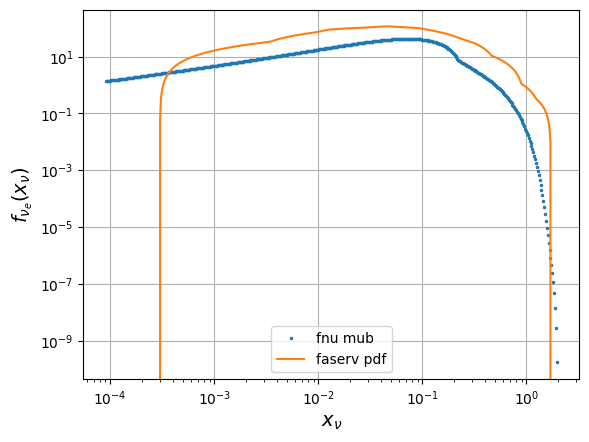

In [23]:
# plt.plot(cont_x,mean_pdf_preproc*mean_nn_pdf*(x_alpha_more_bins.detach().numpy().flatten()),label = 'mult' )
plt.plot(x_vals*2,mean_fnu_mub*x_vals,'o',label="fnu mub",markersize=1.5)
# plt.plot(x_vals,mean_pdf_preproc,label="fpreproc",markersize=1.5)
# plt.plot(x_vals,mean_nn_pdf,label="fnn",markersize=1.5)
# plt.axvline(x=min(xvals_per_obs[0])/14000, color='green', linestyle='--', label='no data to the left of this line')
plt.plot(x_faser*2,faser_pdf_mub*x_vals,label ='faserv pdf')
plt.xlabel(r"$x_{\nu}$",fontsize = 14)
plt.ylabel(r"$f_{\nu_e}(x_{\nu})$",fontsize = 14)
# plt.ylim(10**-1,10**6)
# plt.xlim(10**-4,1.1)
plt.xscale('log')
plt.yscale('log')
plt.grid()
plt.legend()
plt.show()

LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
[44.1 92.7 68.5 66.8 44.3 21.9 21.9]
[49.356308 82.24149  69.17541  75.675095 39.60326  20.109224 20.109224]


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80295/3126794384.py:147: RuntimeWarning: divide by zero encountered in divide
  ratio_center = mean_fnu_mu / faser_pdf_mu
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80295/3126794384.py:148: RuntimeWarning: divide by zero encountered in divide
  ratio_lower = (mean_fnu_mu - error_fnu_mu) / faser_pdf_mu
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80295/3126794384.py:149: RuntimeWarning: divide by zero encountered in divide
  ratio_upper = (mean_fnu_mu + error_fnu_mu) / faser_pdf_mu
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80295/3126794384.py:155: RuntimeWarning: divide by zero encountered in divide
  ratio_center = mean_fnu_mub / faser_pdf_mub
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80295/3126794384.py:156: RuntimeWarning: divide by zero encountered in divide
  ratio_lower = (mean_fnu_mub - error_fnu_mub) / faser_pdf_mub
/var/folders/ph/sg5840xd0fxgcl0kh643h5_000

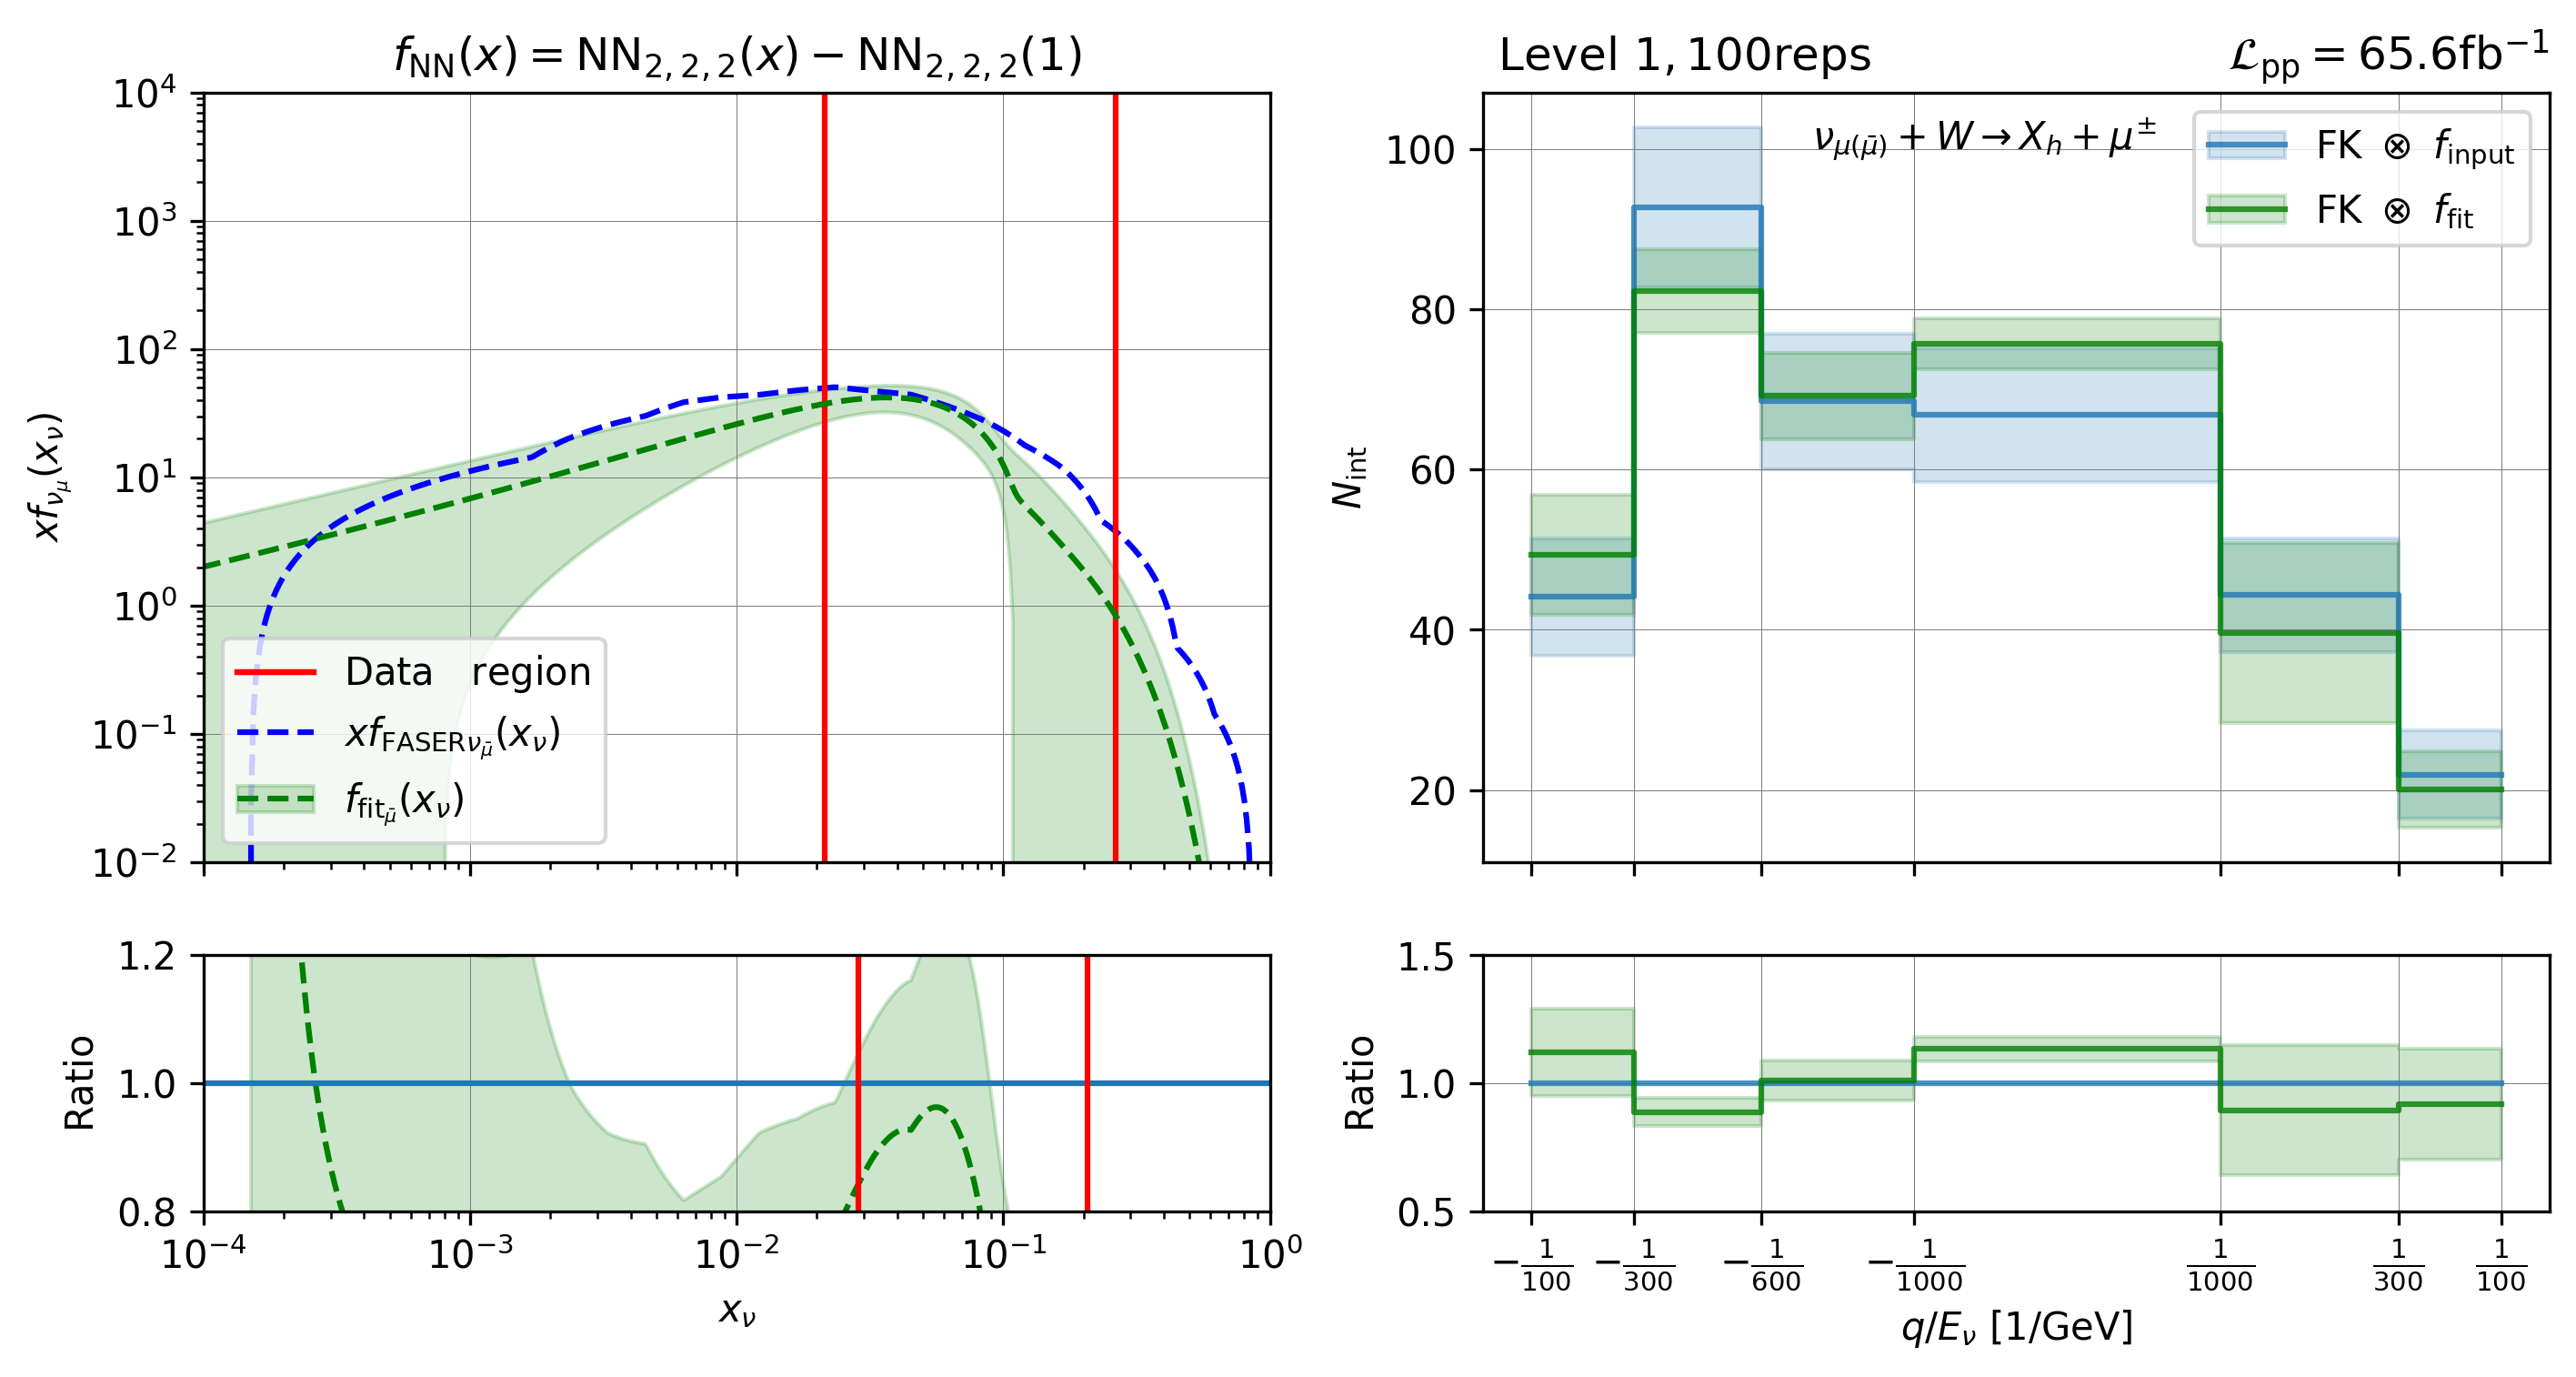

In [25]:
from matplotlib.legend_handler import HandlerTuple
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
from read_faserv_pdf import read_pdf

# Data for plot
import matplotlib.ticker as ticker


def plot_seperate(
    x_vals,
    neutrino_pdfs_mu,
    neutrino_pdfs_mub,
    level0,
    N_event_pred,
    sig_tot,
    xvals_per_obs,
    pid,
):
    pdf = "FASERv_EPOS+POWHEG_7TeV"
    # pdf = "faserv"
    faser_pdf_mu, x_faser = read_pdf(pdf, x_vals, 14)
    faser_pdf_mub, x_faser = read_pdf(pdf, x_vals, -14)
    faser_pdf_mu = faser_pdf_mu * 65.6 / 150 
    faser_pdf_mub = faser_pdf_mub * 65.6 / 150
    mean_fnu_mu = np.mean(neutrino_pdfs_mu, axis=0)
    error_fnu_mu = np.std(neutrino_pdfs_mu, axis=0)

    mean_fnu_mub = np.mean(neutrino_pdfs_mub, axis=0)
    error_fnu_mub = np.std(neutrino_pdfs_mub, axis=0)

    simulated_Enu = level0[0]
    preds_Enu = np.mean(N_event_pred, axis=0)
    pred_stds_Enu = np.std(N_event_pred, axis=0)
    # errors_enu = [5186, 6239, 4165, 1738, 622, 847]
    # errors_enu = np.array(errors_enu)
    # errors_enu = np.sqrt(level0[0])
    errors_enu = sig_tot

    xvals_per_obs = np.append(xvals_per_obs, 1900)
    simulated_Enu = np.append(simulated_Enu, simulated_Enu[-1])
    print(simulated_Enu)
    preds_Enu = np.append(preds_Enu, preds_Enu[-1])
    print(preds_Enu)
    pred_stds_Enu = np.append(pred_stds_Enu, pred_stds_Enu[-1])
    errors_enu = np.append(errors_enu, errors_enu[-1])
    # fig = plt.figure(figsize=(6.8, 3.4), dpi=300)  # 2 rows, 2 columns
    fig = plt.figure(figsize=(10, 5), dpi=300)
    gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1])
    gs.update(left=0.09, right=0.95, top=0.93, hspace=0.18)

    axL = fig.add_subplot(gs[0, 0])
    axR = fig.add_subplot(gs[0, 1])
    axrL = fig.add_subplot(gs[1, 0])
    axrR = fig.add_subplot(gs[1, 1])

    # ======== TOP LEFT (Main plot, f_NN vs f_FASERv ) =============
    # (axLsim_mu,) = axL.plot(
    #     x_vals,
    #     faser_pdf_mu,
    #     linestyle="-",
    #     color="b",
    #     label=r"$f_{\mathrm{FASER}\nu_\mu}(x_\nu)$",
    # )

    (axLsim_mub,) = axL.plot(
        x_vals,
        faser_pdf_mub* x_vals,
        linestyle="--",
        color="b",
        label=r"$f_{\mathrm{FASER}\nu_{\bar{\mu}}}(x_\nu)$",
    )

    axLvert1 = axL.axvline(x=150 / 7000, color="red", label="axvline - full height")
    axLvert2 = axL.axvline(x=1850 / 7000, color="red", label="axvline - full height")
    # axLnnerr_mu = axL.fill_between(
    #     x_vals,
    #     (mean_fnu_mu + error_fnu_mu),
    #     (mean_fnu_mu - error_fnu_mu),
    #     color="green",
    #     alpha=0.2,
    #     label=r"$\pm 1\sigma$",
    # )

    axLnnerr_mub = axL.fill_between(
        x_vals,
        (mean_fnu_mub + error_fnu_mub) * x_vals,
        (mean_fnu_mub - error_fnu_mub)* x_vals,
        color="green",
        alpha=0.2,
        label=r"$\pm 1\sigma$",
    )

    # (axLnn_mu,) = axL.plot(
    #     x_vals,
    #     mean_fnu_mu,
    #     linestyle="-",
    #     color="green",
    #     label=r"$f_{\mathrm{fit}\mu}(x)$",
    # )

    (axLnn_mub,) = axL.plot(
        x_vals,
        mean_fnu_mub* x_vals,
        linestyle="--",
        color="green",
        label=r"$f_{\mathrm{fit}\bar{\mu}}(x)$",
    )

    axL.set_xlim(1e-4, 1)
    axL.set_ylim(1e-2, 1e4)
    axL.set_yscale("log")
    axL.set_xscale("log")
    axL.set_title(
        # r"$f_{\mathrm{NN}}(x) = \mathcal{A} \ x^{1-\alpha}(1-x)^\beta \ \mathrm{NN}(x)$"
        r"$f_{\mathrm{NN}}(x) = \mathrm{NN_{2,2,2}}(x) -\mathrm{NN_{2,2,2}}(1)$"
    )
    axL.set_ylabel(r"$xf_{\nu_\mu}(x_\nu)$")
    axL.set_xticklabels([])
    axL.grid(color="grey", linestyle="-", linewidth=0.25)
    axL.yaxis.set_minor_locator(
        ticker.LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10)
    )
    axL.legend(
        [
            # (axLsim_mu, axLsim_mub),
            # (axLsim_mub),
            (axLvert1, axLvert2),
            (axLsim_mub),
            # (axLnn_mu, axLnnerr_mu),
            (axLnn_mub, axLnnerr_mub),
        ],
        [
            # r"$f_{\mathrm{FASER}\nu_\mu}(x_\nu)$",
            r"$\mathrm{Data}\quad\mathrm{region}$",
            r"$xf_{\mathrm{FASER}\nu_{\bar{\mu}}}(x_\nu)$",
            # r"$f_{\mathrm{fit}_\mu}(x_\nu)$",
            r"$f_{\mathrm{fit}_{\bar{\mu}}}(x_\nu)$",
        ],
        handler_map={tuple: HandlerTuple(ndivide=1)},
        loc="lower left",
    ).set_alpha(0.8)

    # ========== BOTTOM LEFT (Ratio plot, f_NN vs f_FASERv )

    ratio_center = mean_fnu_mu / faser_pdf_mu
    ratio_lower = (mean_fnu_mu - error_fnu_mu) / faser_pdf_mu
    ratio_upper = (mean_fnu_mu + error_fnu_mu) / faser_pdf_mu

    # axrL.plot(x_vals, ratio_center, linestyle="-", color="green")
    # axrL.fill_between(x_vals, ratio_upper, ratio_lower, color="green", alpha=0.2)
    # axrL.plot(x_vals, np.ones(len(x_vals)), linestyle="-", color="tab:blue")

    ratio_center = mean_fnu_mub / faser_pdf_mub
    ratio_lower = (mean_fnu_mub - error_fnu_mub) / faser_pdf_mub
    ratio_upper = (mean_fnu_mub + error_fnu_mub) / faser_pdf_mub

    axrL.plot(x_vals, ratio_center, linestyle="--", color="green")
    axrL.fill_between(x_vals, ratio_upper, ratio_lower, color="green", alpha=0.2)
    axrL.plot(x_vals, np.ones(len(x_vals)), linestyle="-", color="tab:blue")

    axrL.axvline(x=200 / 7000, color="red", label="axvline - full height")
    axrL.axvline(x=1450 / 7000, color="red", label="axvline - full height")

    axrL.set_xscale("log")
    axrL.set_xlim(1e-4, 1)
    axrL.set_ylim(0.8, 1.2)
    axrL.grid(color="grey", linestyle="-", linewidth=0.25)
    axrL.set_ylabel(r"$\mathrm{Ratio}$")
    axrL.set_xlabel(r"$x_\nu$")

    # =========== TOP RIGHT (Rates Enu vs FK otimes f_NN)

    xvals_per_obs = [-1500, -1100, -600, 0.0, 1200, 1900, 2300]

    # xplot_Enumu = 1 / xplot_Enumu
    # xplot_Enumu[-1] = -1 / 1000
    # xplot_ticks = np.array(
    #     [-1 / 100, -1 / 300, -1 / 600, -1 / 1000, 1 / 1000, 1 / 300, 1 / 100]
    # )
    # ticks = np.linspace(0, 1, len(xplot_ticks))
    # xplot_Enumu = np.interp(-xplot_Enumu, xplot_ticks, ticks)
    # xplot_Enumub = 1 / xplot_Enumub
    # xplot_Enumub[-1] = -1 / 1000
    # xplot_Enumub = np.interp(xplot_Enumub, xplot_ticks, ticks)

    # sorted_indices = np.argsort(xvals_per_obs)
    # xvals_per_obs = xvals_per_obs[sorted_indices]
    # simulated_Enu = simulated_Enu[sorted_indices]
    # errors_enu = errors_enu[sorted_indices]
    # preds_Enu = preds_Enu[sorted_indices]
    # pred_stds_Enu = pred_stds_Enu[sorted_indices]

    (axRsim,) = axR.plot(
        xvals_per_obs,
        simulated_Enu,
        drawstyle="steps-post",
        color="tab:blue",
        alpha=0.8,
    )
    axRsimerr = axR.fill_between(
        xvals_per_obs,
        simulated_Enu + errors_enu,
        simulated_Enu - errors_enu,
        step="post",
        color="tab:blue",
        alpha=0.2,
        label=r"POWHEG $E_\nu$",
    )

    (axRpred,) = axR.plot(
        xvals_per_obs,
        preds_Enu,
        color="green",
        drawstyle="steps-post",
        alpha=0.8,
        label=r"$\mathrm{NN}(E_\nu)$",
    )
    axRprederr = axR.fill_between(
        xvals_per_obs,
        (preds_Enu + pred_stds_Enu),
        (preds_Enu - pred_stds_Enu),
        color="green",
        alpha=0.2,
        step="post",
        label=r"$\pm 1\sigma$",
    )
    axR.legend(
        [(axRsimerr, axRsim), (axRprederr, axRpred)],
        [
            r"$\mathrm{FK} \ \otimes \ f_{\mathrm{input}}$",
            r"$\mathrm{FK} \ \otimes \ f_{\mathrm{fit}}$",
        ],
        handler_map={tuple: HandlerTuple(ndivide=1)},
        loc="upper right",
    ).set_alpha(0.8)
    # axR.set_xlim(0)
    # axR.set_ylim(0)
    tick_labels = [
        r"$-\frac{1}{100}$",
        r"$-\frac{1}{300}$",
        r"$-\frac{1}{600}$",
        r"$-\frac{1}{1000}$",
        r"$\frac{1}{1000}$",
        r"$\frac{1}{300}$",
        r"$\frac{1}{100}$",
    ]

    # Use `xvals_per_obs` positions for labels
    axR.set_xticks(xvals_per_obs)
    axR.set_xticklabels(tick_labels)

    axR.grid(color="grey", linestyle="-", linewidth=0.25)
    axR.set_xticklabels([])
    axR.set_title(r"$\mathcal{L}_{\mathrm{pp}} = 65.6 \mathrm{fb}^{-1}$", loc="right")
    axR.set_title(r"$\ \mathrm{Level\ 1},100 \mathrm{reps}$", loc="left")
    axR.text(-400, 100, r"$\nu_{\mu(\bar{\mu})} + W \rightarrow X_h+  \mu^{\pm} $")
    axR.set_ylabel(r"$N_{\mathrm{int}}$")

    ratio_center_pred = preds_Enu / simulated_Enu
    ratio_lower_pred = (preds_Enu - pred_stds_Enu) / simulated_Enu
    ratio_upper_pred = (preds_Enu + pred_stds_Enu) / simulated_Enu
    ratio_upper_sim = (simulated_Enu + errors_enu) / simulated_Enu
    ratio_lower_sim = (simulated_Enu + errors_enu) / simulated_Enu

    axrR.fill_between(
        xvals_per_obs, ratio_upper_sim, ratio_lower_sim, step="post", alpha=0.2
    )
    axrR.plot(
        xvals_per_obs, np.ones(len(simulated_Enu)), drawstyle="steps-post", alpha=0.8
    )

    axrR.fill_between(
        xvals_per_obs,
        ratio_upper_pred,
        ratio_lower_pred,
        step="post",
        alpha=0.2,
        color="green",
    )
    axrR.plot(
        xvals_per_obs,
        ratio_center_pred,
        drawstyle="steps-post",
        alpha=0.8,
        color="green",
    )

    axrR.set_ylabel(r"$\mathrm{Ratio}$")
    axrR.set_xlabel(r"$q/E_\nu \ [\mathrm{1/GeV}]$")
    axrR.set_ylim(0.5, 1.5)
    # axrR.set_xlim(0)
    axrR.grid(color="grey", linestyle="-", linewidth=0.25)

    tick_labels = [
        r"$-\frac{1}{100}$",
        r"$-\frac{1}{300}$",
        r"$-\frac{1}{600}$",
        r"$-\frac{1}{1000}$",
        r"$\frac{1}{1000}$",
        r"$\frac{1}{300}$",
        r"$\frac{1}{100}$",
    ]

    # Use `xvals_per_obs` positions for labels
    axrR.set_xticks(xvals_per_obs)
    axrR.set_xticklabels(tick_labels)

    axrR.set_xlabel(r"$q/E_\nu \ [\mathrm{1/GeV}]$")

    plt.savefig("faserdata_mub.pdf")

sig_tot = 1/np.sqrt(np.diag(cov_matrix)) 
plot_seperate(x_vals, neutrino_pdfs_mu, neutrino_pdfs_mub,level0, N_event_pred, sig_tot, xvals_per_obs,14)

[44.1 92.7 68.5 66.8 44.3 21.9 21.9]LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000

[49.356308 82.24149  69.17541  75.675095 39.60326  20.109224 20.109224]


/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80295/3241649448.py:147: RuntimeWarning: divide by zero encountered in divide
  ratio_center = mean_fnu_mu / faser_pdf_mu
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80295/3241649448.py:148: RuntimeWarning: divide by zero encountered in divide
  ratio_lower = (mean_fnu_mu - error_fnu_mu) / faser_pdf_mu
/var/folders/ph/sg5840xd0fxgcl0kh643h5_00000gp/T/ipykernel_80295/3241649448.py:149: RuntimeWarning: divide by zero encountered in divide
  ratio_upper = (mean_fnu_mu + error_fnu_mu) / faser_pdf_mu


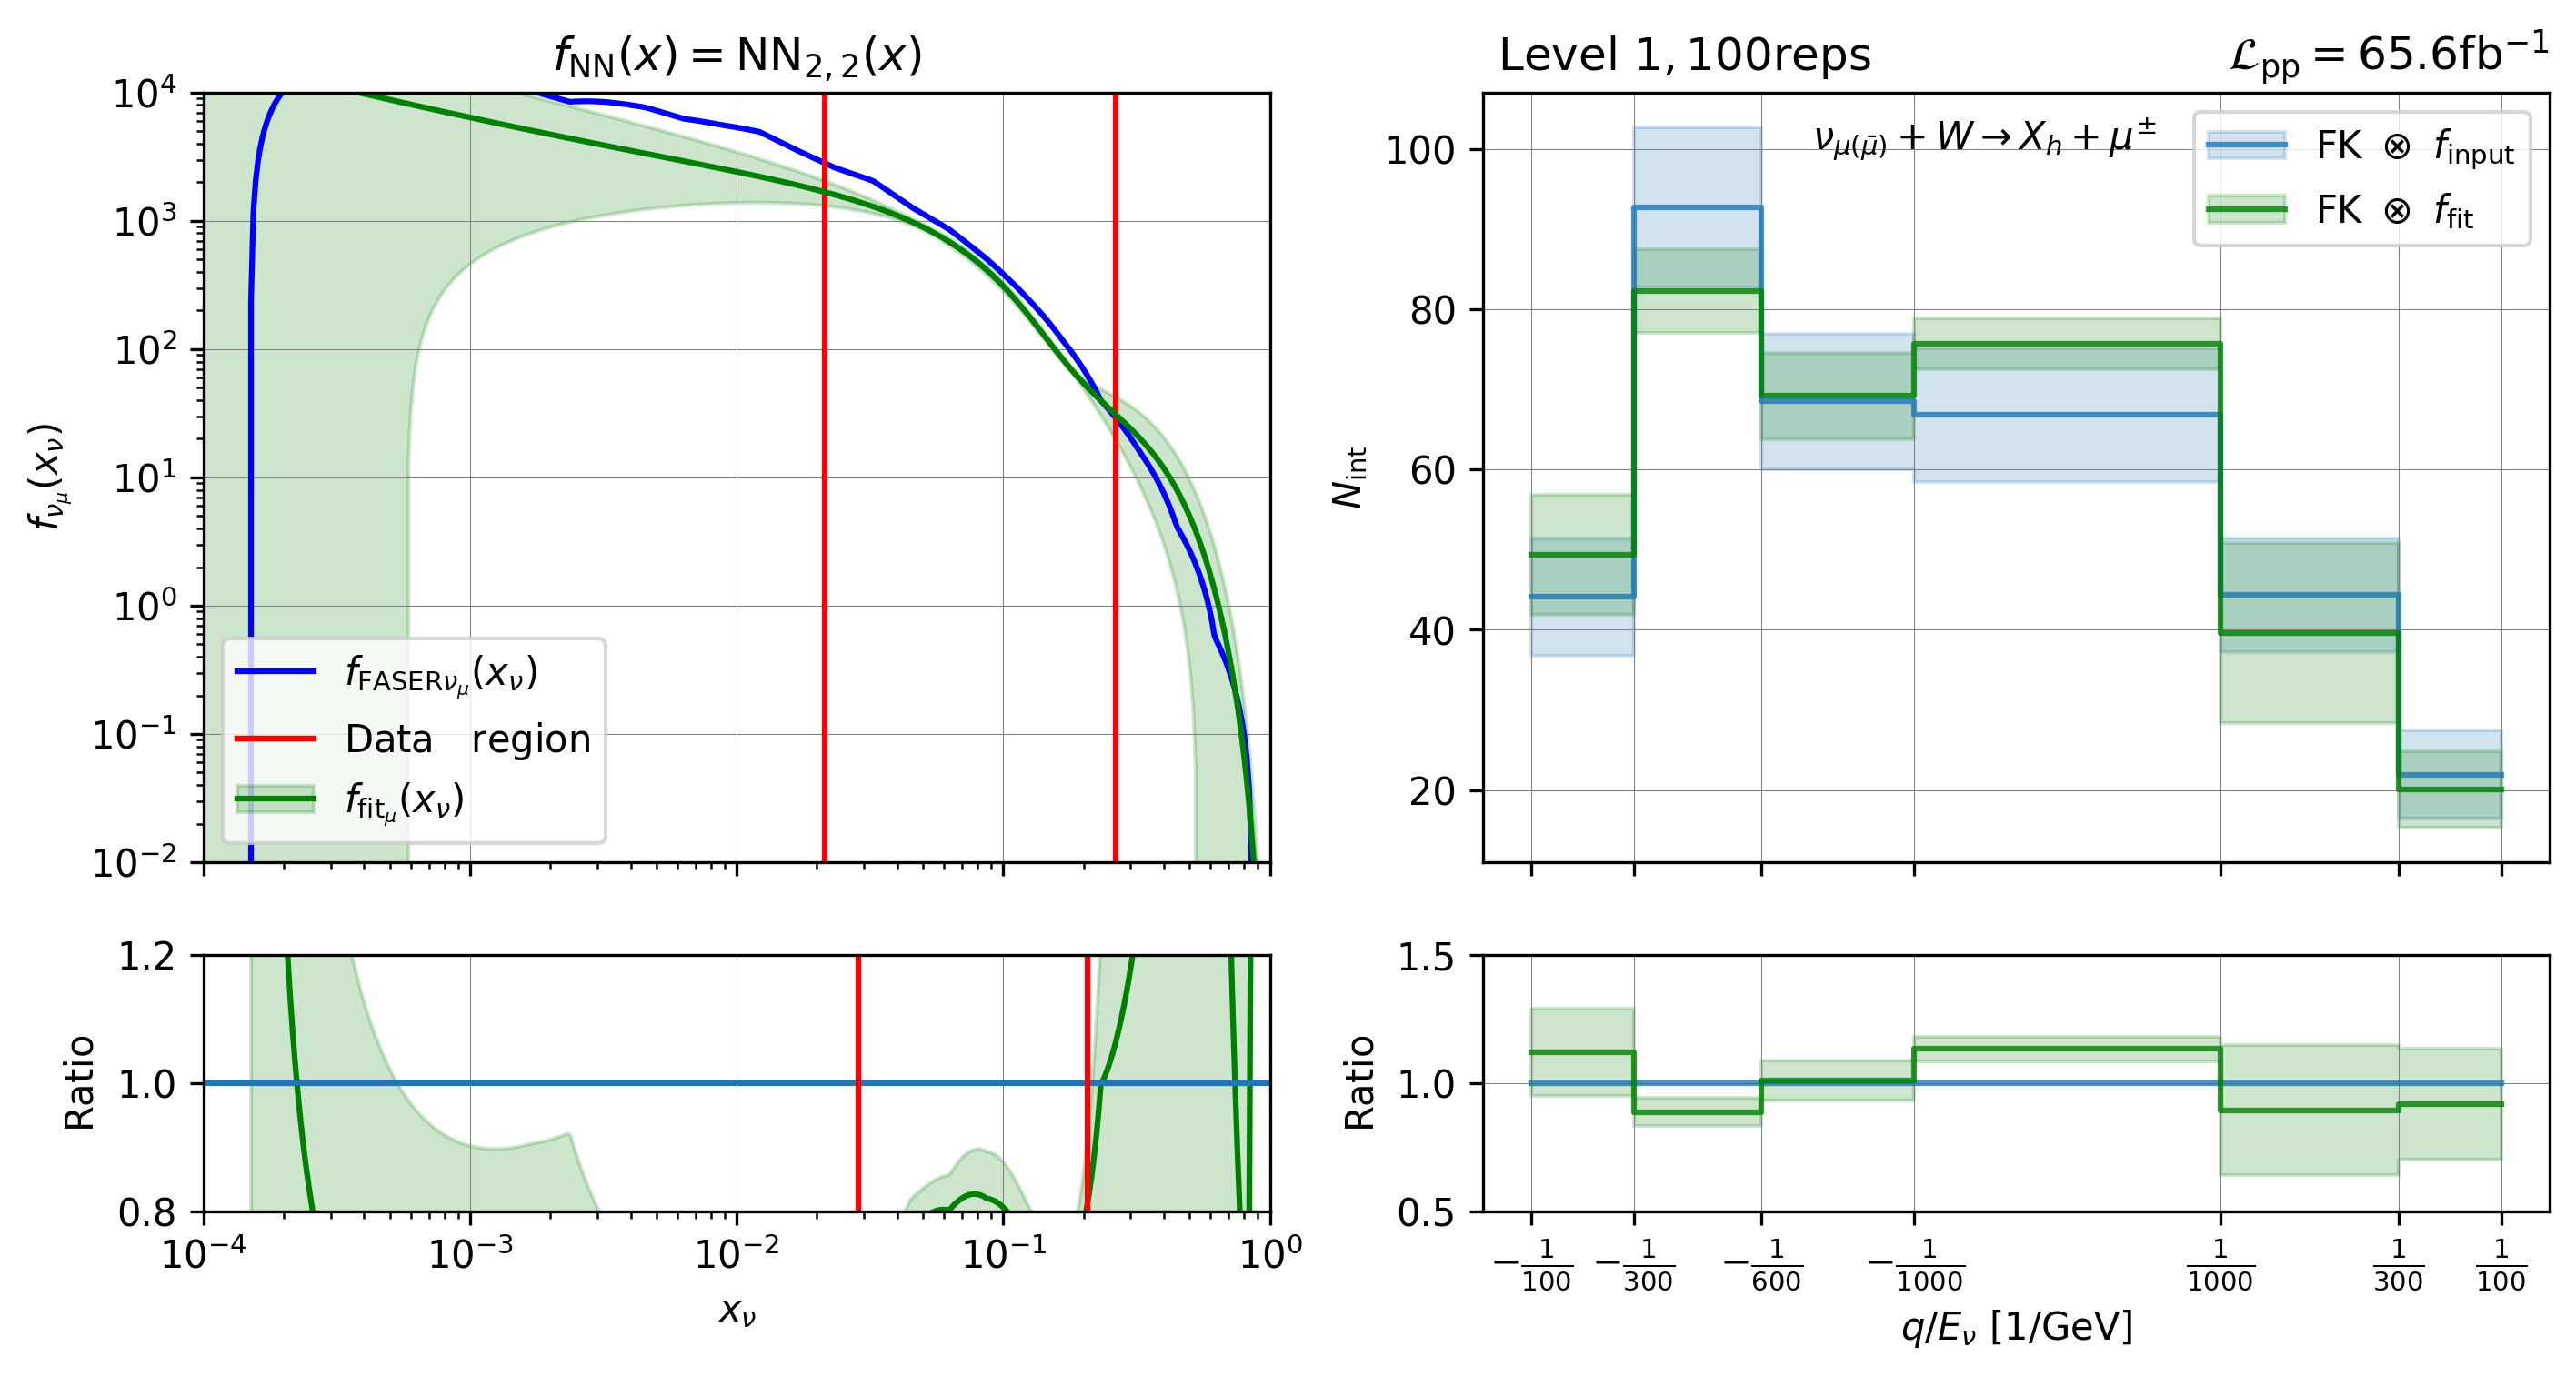

In [26]:
from matplotlib.legend_handler import HandlerTuple
from matplotlib import gridspec
import matplotlib.pyplot as plt
import numpy as np
from read_faserv_pdf import read_pdf

# Data for plot
import matplotlib.ticker as ticker


def plot_seperate(
    x_vals,
    neutrino_pdfs_mu,
    neutrino_pdfs_mub,
    level0,
    N_event_pred,
    sig_tot,
    xvals_per_obs,
    pid,
):
    pdf = "FASERv_EPOS+POWHEG_7TeV"
    # pdf = "faserv"
    faser_pdf_mu, x_faser = read_pdf(pdf, x_vals, 14)
    faser_pdf_mub, x_faser = read_pdf(pdf, x_vals, -14)
    faser_pdf_mu = faser_pdf_mu * 65.6 / 150 
    faser_pdf_mub = faser_pdf_mub * 65.6 / 150
    mean_fnu_mu = np.mean(neutrino_pdfs_mu, axis=0)
    error_fnu_mu = np.std(neutrino_pdfs_mu, axis=0)

    mean_fnu_mub = np.mean(neutrino_pdfs_mub, axis=0)
    error_fnu_mub = np.std(neutrino_pdfs_mub, axis=0)

    simulated_Enu = level0[0]
    preds_Enu = np.mean(N_event_pred, axis=0)
    pred_stds_Enu = np.std(N_event_pred, axis=0)
    # errors_enu = [5186, 6239, 4165, 1738, 622, 847]
    # errors_enu = np.array(errors_enu)
    # errors_enu = np.sqrt(level0[0])
    errors_enu = sig_tot

    xvals_per_obs = np.append(xvals_per_obs, 1900)
    simulated_Enu = np.append(simulated_Enu, simulated_Enu[-1])
    print(simulated_Enu)
    preds_Enu = np.append(preds_Enu, preds_Enu[-1])
    print(preds_Enu)
    pred_stds_Enu = np.append(pred_stds_Enu, pred_stds_Enu[-1])
    errors_enu = np.append(errors_enu, errors_enu[-1])
    # fig = plt.figure(figsize=(6.8, 3.4), dpi=300)  # 2 rows, 2 columns
    fig = plt.figure(figsize=(10, 5), dpi=300)
    gs = gridspec.GridSpec(2, 2, height_ratios=[3, 1])
    gs.update(left=0.09, right=0.95, top=0.93, hspace=0.18)

    axL = fig.add_subplot(gs[0, 0])
    axR = fig.add_subplot(gs[0, 1])
    axrL = fig.add_subplot(gs[1, 0])
    axrR = fig.add_subplot(gs[1, 1])

    # ======== TOP LEFT (Main plot, f_NN vs f_FASERv ) =============
    (axLsim_mu,) = axL.plot(
        x_vals,
        faser_pdf_mu,
        linestyle="-",
        color="b",
        label=r"$f_{\mathrm{FASER}\nu_\mu}(x_\nu)$",
    )

    # (axLsim_mub,) = axL.plot(
    #     x_vals,
    #     faser_pdf_mub,
    #     linestyle="--",
    #     color="b",
    #     label=r"$f_{\mathrm{FASER}\nu_{\bar{\mu}}}(x_\nu)$",
    # )

    axLvert1 = axL.axvline(x=150 / 7000, color="red", label="axvline - full height")
    axLvert2 = axL.axvline(x=1850 / 7000, color="red", label="axvline - full height")
    axLnnerr_mu = axL.fill_between(
        x_vals,
        (mean_fnu_mu + error_fnu_mu),
        (mean_fnu_mu - error_fnu_mu),
        color="green",
        alpha=0.2,
        label=r"$\pm 1\sigma$",
    )

    # axLnnerr_mub = axL.fill_between(
    #     x_vals,
    #     (mean_fnu_mub + error_fnu_mub),
    #     (mean_fnu_mub - error_fnu_mub),
    #     color="green",
    #     alpha=0.2,
    #     label=r"$\pm 1\sigma$",
    # )

    (axLnn_mu,) = axL.plot(
        x_vals,
        mean_fnu_mu,
        linestyle="-",
        color="green",
        label=r"$f_{\mathrm{fit}\mu}(x)$",
    )

    # (axLnn_mub,) = axL.plot(
    #     x_vals,
    #     mean_fnu_mub,
    #     linestyle="--",
    #     color="green",
    #     label=r"$f_{\mathrm{fit}\bar{\mu}}(x)$",
    # )

    axL.set_xlim(1e-4, 1)
    axL.set_ylim(1e-2, 1e4)
    axL.set_yscale("log")
    axL.set_xscale("log")
    axL.set_title(
        # r"$f_{\mathrm{NN}}(x) = \mathcal{A} \ x^{1-\alpha}(1-x)^\beta \ \mathrm{NN}(x)$"
        r"$f_{\mathrm{NN}}(x) = \mathrm{NN_{2,2}}(x) $"
    )
    axL.set_ylabel(r"$f_{\nu_\mu}(x_\nu)$")
    axL.set_xticklabels([])
    axL.grid(color="grey", linestyle="-", linewidth=0.25)
    axL.yaxis.set_minor_locator(
        ticker.LogLocator(base=10.0, subs=np.arange(1.0, 10.0) * 0.1, numticks=10)
    )
    axL.legend(
        [
            # (axLsim_mu, axLsim_mub),
            (axLsim_mu),
            (axLvert1, axLvert2),
            # (axLsim_mub),
            (axLnn_mu, axLnnerr_mu),
            # (axLnn_mub, axLnnerr_mub),
        ],
        [
            r"$f_{\mathrm{FASER}\nu_\mu}(x_\nu)$",
            r"$\mathrm{Data}\quad\mathrm{region}$",
            # r"$f_{\mathrm{FASER}\nu_{\bar{\mu}}}(x_\nu)$",
            r"$f_{\mathrm{fit}_\mu}(x_\nu)$",
            # r"$f_{\mathrm{fit}_{\bar{\mu}}}(x_\nu)$",
        ],
        handler_map={tuple: HandlerTuple(ndivide=1)},
        loc="lower left",
    ).set_alpha(0.8)

    # ========== BOTTOM LEFT (Ratio plot, f_NN vs f_FASERv )

    ratio_center = mean_fnu_mu / faser_pdf_mu
    ratio_lower = (mean_fnu_mu - error_fnu_mu) / faser_pdf_mu
    ratio_upper = (mean_fnu_mu + error_fnu_mu) / faser_pdf_mu

    axrL.plot(x_vals, ratio_center, linestyle="-", color="green")
    axrL.fill_between(x_vals, ratio_upper, ratio_lower, color="green", alpha=0.2)
    axrL.plot(x_vals, np.ones(len(x_vals)), linestyle="-", color="tab:blue")

    # ratio_center = mean_fnu_mub / faser_pdf_mub
    # ratio_lower = (mean_fnu_mub - error_fnu_mub) / faser_pdf_mub
    # ratio_upper = (mean_fnu_mub + error_fnu_mub) / faser_pdf_mub

    # axrL.plot(x_vals, ratio_center, linestyle="--", color="green")
    # axrL.fill_between(x_vals, ratio_upper, ratio_lower, color="green", alpha=0.2)
    # axrL.plot(x_vals, np.ones(len(x_vals)), linestyle="-", color="tab:blue")

    axrL.axvline(x=200 / 7000, color="red", label="axvline - full height")
    axrL.axvline(x=1450 / 7000, color="red", label="axvline - full height")

    axrL.set_xscale("log")
    axrL.set_xlim(1e-4, 1)
    axrL.set_ylim(0.8, 1.2)
    axrL.grid(color="grey", linestyle="-", linewidth=0.25)
    axrL.set_ylabel(r"$\mathrm{Ratio}$")
    axrL.set_xlabel(r"$x_\nu$")

    # =========== TOP RIGHT (Rates Enu vs FK otimes f_NN)

    xvals_per_obs = [-1500, -1100, -600, 0.0, 1200, 1900, 2300]

    # xplot_Enumu = 1 / xplot_Enumu
    # xplot_Enumu[-1] = -1 / 1000
    # xplot_ticks = np.array(
    #     [-1 / 100, -1 / 300, -1 / 600, -1 / 1000, 1 / 1000, 1 / 300, 1 / 100]
    # )
    # ticks = np.linspace(0, 1, len(xplot_ticks))
    # xplot_Enumu = np.interp(-xplot_Enumu, xplot_ticks, ticks)
    # xplot_Enumub = 1 / xplot_Enumub
    # xplot_Enumub[-1] = -1 / 1000
    # xplot_Enumub = np.interp(xplot_Enumub, xplot_ticks, ticks)

    # sorted_indices = np.argsort(xvals_per_obs)
    # xvals_per_obs = xvals_per_obs[sorted_indices]
    # simulated_Enu = simulated_Enu[sorted_indices]
    # errors_enu = errors_enu[sorted_indices]
    # preds_Enu = preds_Enu[sorted_indices]
    # pred_stds_Enu = pred_stds_Enu[sorted_indices]

    (axRsim,) = axR.plot(
        xvals_per_obs,
        simulated_Enu,
        drawstyle="steps-post",
        color="tab:blue",
        alpha=0.8,
    )
    axRsimerr = axR.fill_between(
        xvals_per_obs,
        simulated_Enu + errors_enu,
        simulated_Enu - errors_enu,
        step="post",
        color="tab:blue",
        alpha=0.2,
        label=r"POWHEG $E_\nu$",
    )

    (axRpred,) = axR.plot(
        xvals_per_obs,
        preds_Enu,
        color="green",
        drawstyle="steps-post",
        alpha=0.8,
        label=r"$\mathrm{NN}(E_\nu)$",
    )
    axRprederr = axR.fill_between(
        xvals_per_obs,
        (preds_Enu + pred_stds_Enu),
        (preds_Enu - pred_stds_Enu),
        color="green",
        alpha=0.2,
        step="post",
        label=r"$\pm 1\sigma$",
    )
    axR.legend(
        [(axRsimerr, axRsim), (axRprederr, axRpred)],
        [
            r"$\mathrm{FK} \ \otimes \ f_{\mathrm{input}}$",
            r"$\mathrm{FK} \ \otimes \ f_{\mathrm{fit}}$",
        ],
        handler_map={tuple: HandlerTuple(ndivide=1)},
        loc="upper right",
    ).set_alpha(0.8)
    # axR.set_xlim(0)
    # axR.set_ylim(0)
    tick_labels = [
        r"$-\frac{1}{100}$",
        r"$-\frac{1}{300}$",
        r"$-\frac{1}{600}$",
        r"$-\frac{1}{1000}$",
        r"$\frac{1}{1000}$",
        r"$\frac{1}{300}$",
        r"$\frac{1}{100}$",
    ]

    # Use `xvals_per_obs` positions for labels
    axR.set_xticks(xvals_per_obs)
    axR.set_xticklabels(tick_labels)

    axR.grid(color="grey", linestyle="-", linewidth=0.25)
    axR.set_xticklabels([])
    axR.set_title(r"$\mathcal{L}_{\mathrm{pp}} = 65.6 \mathrm{fb}^{-1}$", loc="right")
    axR.set_title(r"$\ \mathrm{Level\ 1},100 \mathrm{reps}$", loc="left")
    axR.text(-400, 100, r"$\nu_{\mu(\bar{\mu})} + W \rightarrow X_h+  \mu^{\pm} $")
    axR.set_ylabel(r"$N_{\mathrm{int}}$")

    ratio_center_pred = preds_Enu / simulated_Enu
    ratio_lower_pred = (preds_Enu - pred_stds_Enu) / simulated_Enu
    ratio_upper_pred = (preds_Enu + pred_stds_Enu) / simulated_Enu
    ratio_upper_sim = (simulated_Enu + errors_enu) / simulated_Enu
    ratio_lower_sim = (simulated_Enu + errors_enu) / simulated_Enu

    axrR.fill_between(
        xvals_per_obs, ratio_upper_sim, ratio_lower_sim, step="post", alpha=0.2
    )
    axrR.plot(
        xvals_per_obs, np.ones(len(simulated_Enu)), drawstyle="steps-post", alpha=0.8
    )

    axrR.fill_between(
        xvals_per_obs,
        ratio_upper_pred,
        ratio_lower_pred,
        step="post",
        alpha=0.2,
        color="green",
    )
    axrR.plot(
        xvals_per_obs,
        ratio_center_pred,
        drawstyle="steps-post",
        alpha=0.8,
        color="green",
    )

    axrR.set_ylabel(r"$\mathrm{Ratio}$")
    axrR.set_xlabel(r"$q/E_\nu \ [\mathrm{1/GeV}]$")
    axrR.set_ylim(0.5, 1.5)
    # axrR.set_xlim(0)
    axrR.grid(color="grey", linestyle="-", linewidth=0.25)

    tick_labels = [
        r"$-\frac{1}{100}$",
        r"$-\frac{1}{300}$",
        r"$-\frac{1}{600}$",
        r"$-\frac{1}{1000}$",
        r"$\frac{1}{1000}$",
        r"$\frac{1}{300}$",
        r"$\frac{1}{100}$",
    ]

    # Use `xvals_per_obs` positions for labels
    axrR.set_xticks(xvals_per_obs)
    axrR.set_xticklabels(tick_labels)

    axrR.set_xlabel(r"$q/E_\nu \ [\mathrm{1/GeV}]$")

    plt.savefig("faserdata_mu.pdf")

sig_tot = 1/np.sqrt(np.diag(cov_matrix)) 
plot_seperate(x_vals, neutrino_pdfs_mu, neutrino_pdfs_mub,level0, N_event_pred, sig_tot, xvals_per_obs,14)

[7.3287106 9.947361  8.449261  8.328265  7.042017  5.5054517]
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
LHAPDF 6.5.4 loading /opt/anaconda3/envs/ML_fit/share/LHAPDF/FASERv_EPOS+POWHEG_7TeV/FASERv_EPOS+POWHEG_7TeV_0000.dat
FASERv_EPOS+POWHEG_7TeV PDF set, member #0, version 1; LHAPDF ID = 70001000
[44.1 92.7 68.5 66.8 44.3 21.9 21.9]
[49.356308 82.24149  69.17541  75.675095 39.60326  20.109224 20.109224]


/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results_faser_data.py:145: RuntimeWarning: divide by zero encountered in divide
  ratio_center = mean_fnu_mu / faser_pdf_mu
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results_faser_data.py:146: RuntimeWarning: divide by zero encountered in divide
  ratio_lower = (mean_fnu_mu - error_fnu_mu) / faser_pdf_mu
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results_faser_data.py:147: RuntimeWarning: divide by zero encountered in divide
  ratio_upper = (mean_fnu_mu + error_fnu_mu) / faser_pdf_mu
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results_faser_data.py:153: RuntimeWarning: divide by zero encountered in divide
  ratio_center = mean_fnu_mub / faser_pdf_mub
/Users/jukkajohn/Masterscriptie/faser_nufluxes_ml/ML_fit_enu/src/ML_fit_neutrinos/plot_results_faser_data.py:154: RuntimeW

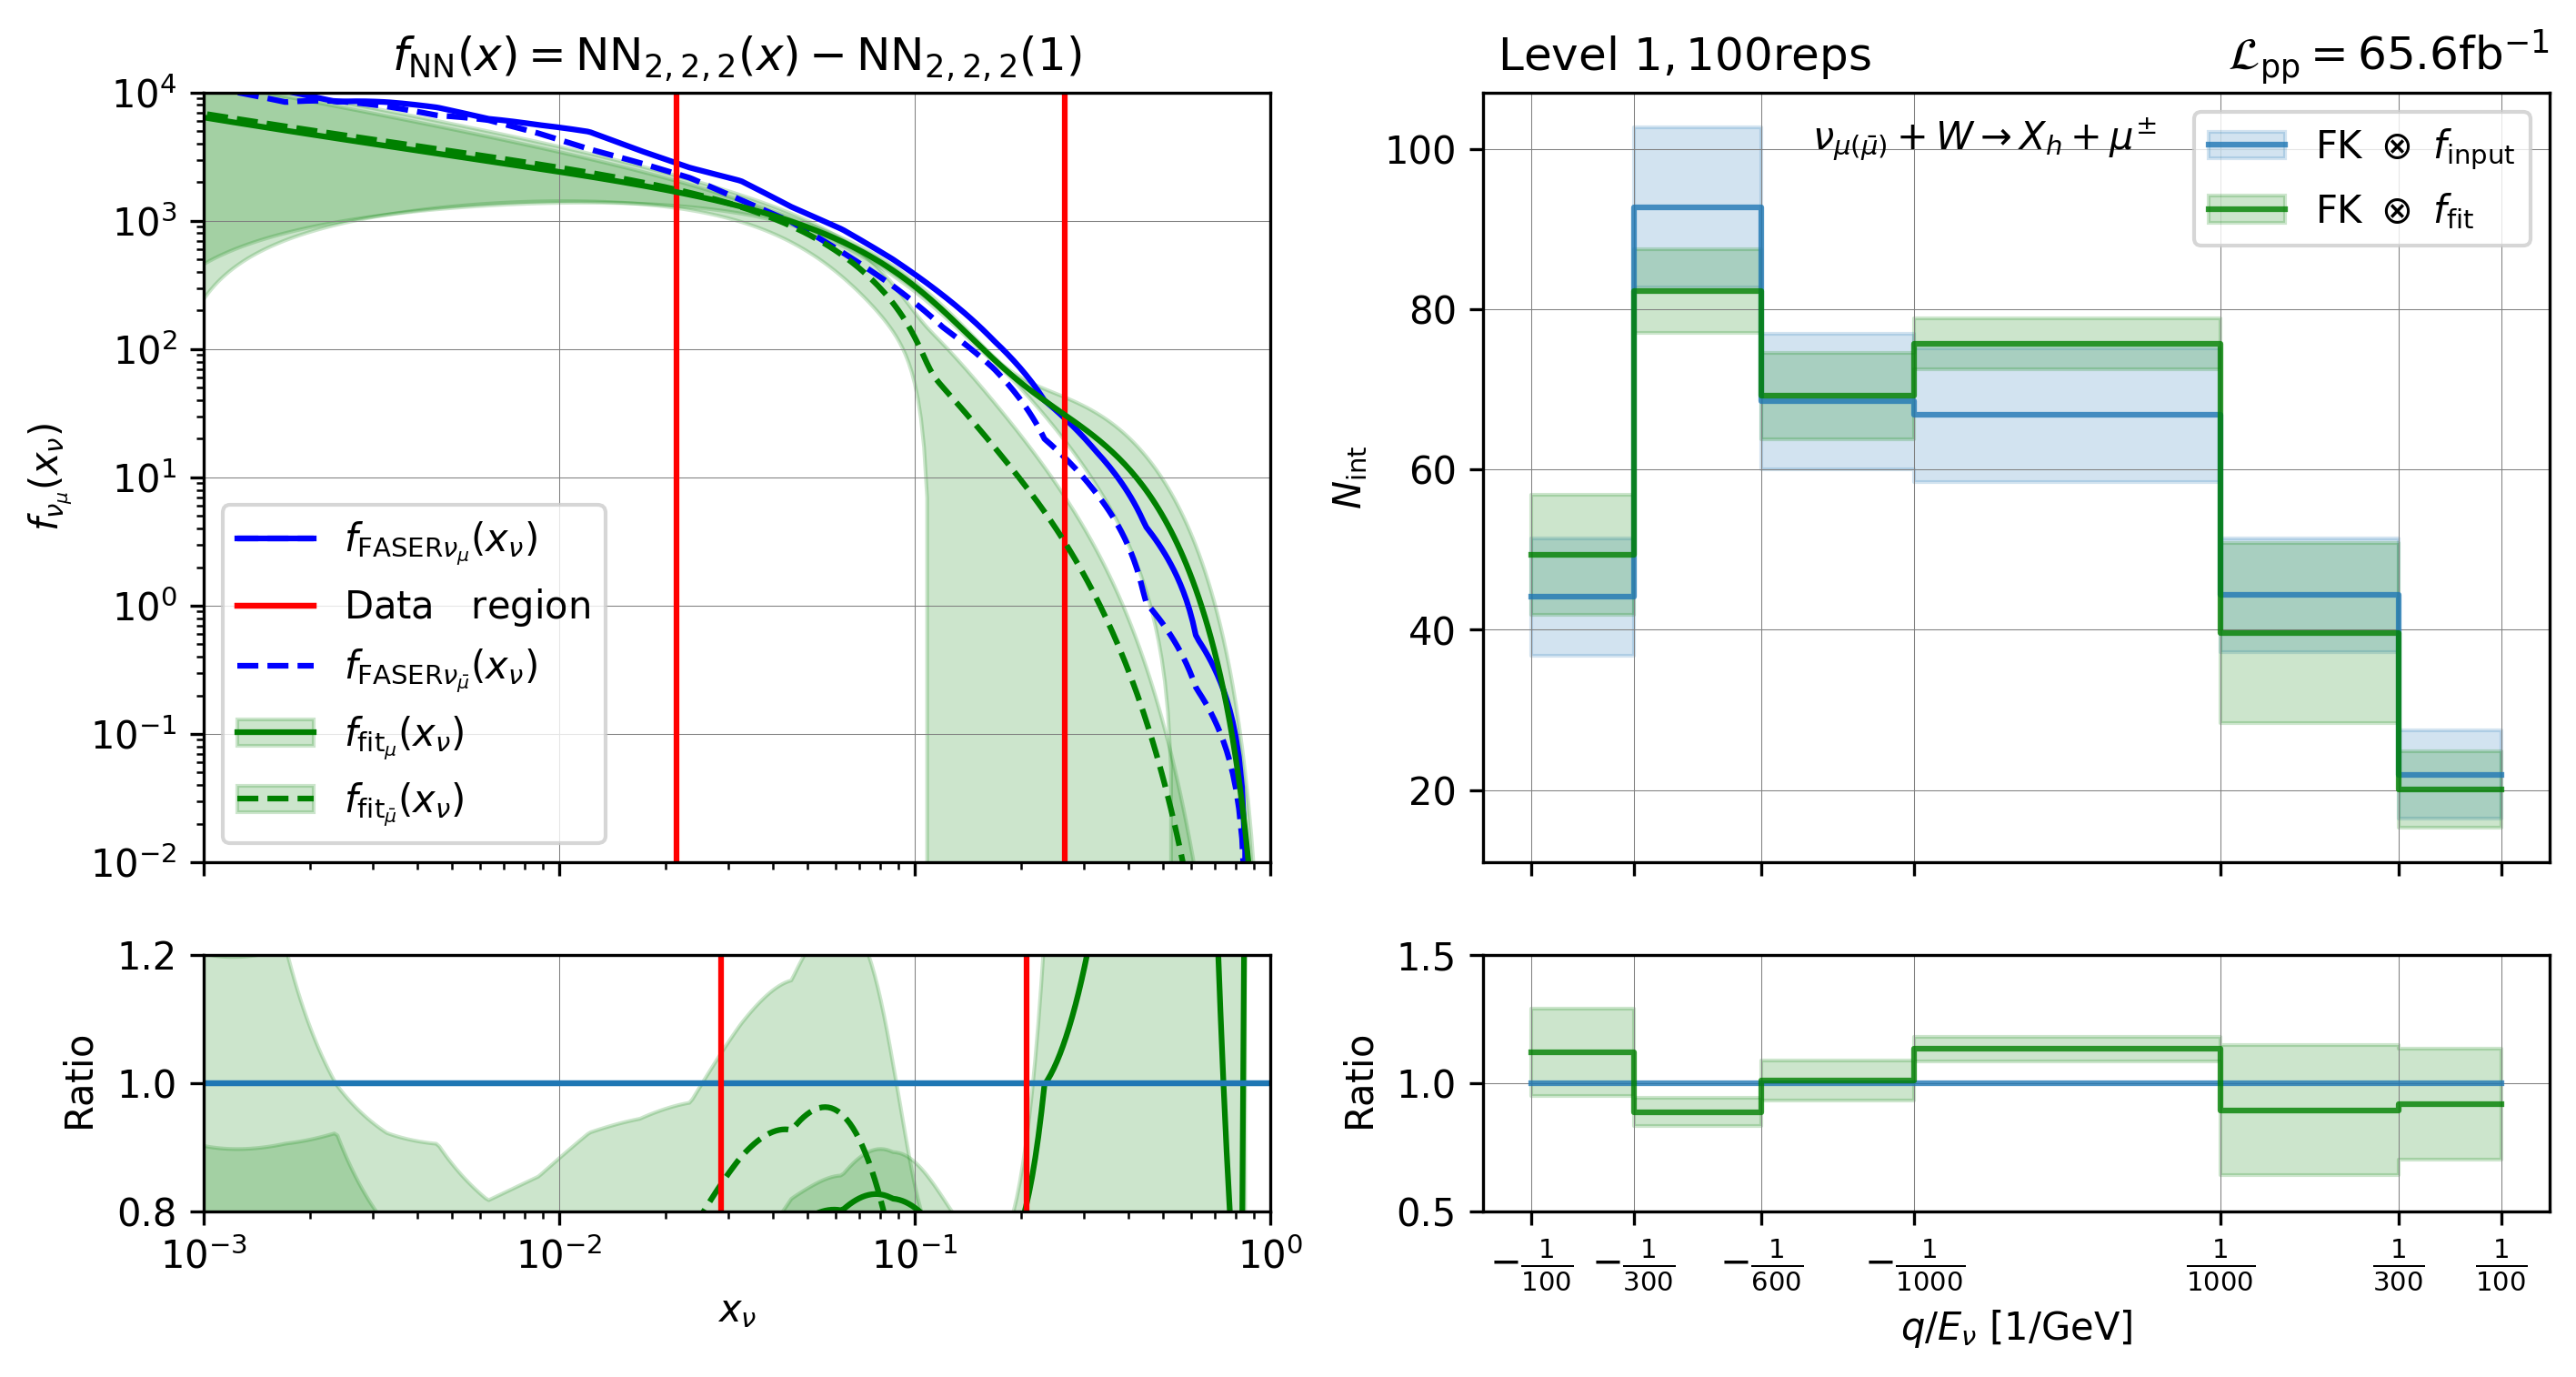

In [27]:
from plot_results_faser_data import plot
# sig_tot = np.sqrt(sig_sys+sig_stat)
sig_tot = 1/np.sqrt(np.diag(cov_matrix)) 
print(sig_tot)
plot(x_vals, neutrino_pdfs_mu, neutrino_pdfs_mub,level0, N_event_pred, sig_tot, xvals_per_obs,14)
# plot(x_vals, neutrino_pdfs_mub, level0, N_event_pred, sig_tot, xvals_per_obs,-14)

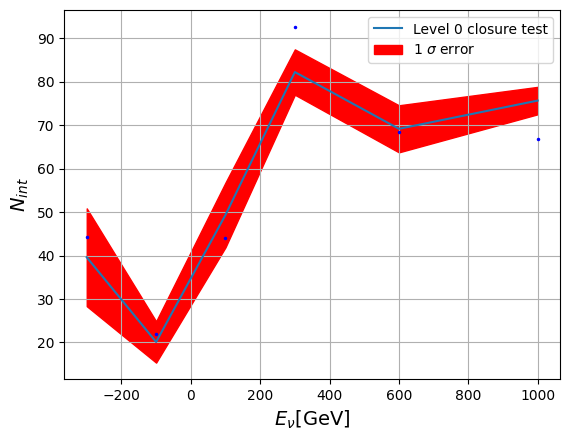

In [28]:

mean_N_event_fits = np.mean(N_event_pred,axis=0)
sigma_N_event_fits = np.std(N_event_pred,axis=0)

mean_N_event_fit = mean_N_event_fits.flatten()
sigma_N_event_fit = sigma_N_event_fits.flatten()
xvals_per_obs = np.array(xvals_per_obs)
sorted_indices = np.argsort(xvals_per_obs)

# Sort both arrays using the same indices
sorted_xvals_per_obs = xvals_per_obs[sorted_indices]
sorted_mean_N_event_fit = mean_N_event_fit[sorted_indices]
sorted_sigma_N_event_fit = sigma_N_event_fit[sorted_indices]
level0data = level0[0]
sorted_level0 = level0data[sorted_indices]

plt.plot(sorted_xvals_per_obs,sorted_mean_N_event_fit,label="Level 0 closure test")

plt.fill_between(sorted_xvals_per_obs,(sorted_mean_N_event_fit+sorted_sigma_N_event_fit),(sorted_mean_N_event_fit-sorted_sigma_N_event_fit),label=r"1 $\sigma$ error",color = 'red')

# plt.plot(xvals_per_obs[i],events_per_obs[i],'go',markersize=1.5)
plt.plot(sorted_xvals_per_obs,sorted_level0,'bo',markersize=1.5)
# plt.errorbar(xvals_per_obs[i],events_per_obs[i],yerr=np.sqrt(sig_tot),label='POWHEG +PY8 NLO',color = 'green',alpha=0.6 )
# plt.fill_between(xvals_per_obs[i],events_per_obs[i]+np.sqrt(sig_tot), events_per_obs[i]-np.sqrt(sig_tot),color = 'green',alpha=0.6)
plt.xlabel(r"$E_{\nu}$[GeV]",fontsize = 14)
plt.ylabel(r"$N_{int}$",fontsize = 14)
plt.grid()
plt.legend()
# plt.savefig('N_int_fit.pdf')
plt.show()
    

In [29]:
# Quantitative validation of PDF uncertainties in closure tests
# theoretical prediction for # of events
pdf = "faserv"
lowx = -8
n=50
# x_vals = generate_grid(lowx,n)

faser_pdf,x_faser = read_pdf(pdf,x_vals)
postfit_measures = Measures(cov_matrix, pdf, N_event_pred)
delta_chi = postfit_measures.compute_delta_chi(num_obs, fk_tables, binwidths, level1[0],x_vals)
print(f'delta chi^2 = {delta_chi}')

phi_chi_squared = postfit_measures.compute_phi(data, chi_squares)
print(f'phi level 2 = {phi_chi_squared}')

dist,xnu  = postfit_measures.compute_distance(neutrino_pdfs,x_vals)
plt.plot(xnu,dist,'o')
plt.ylabel('distance to truth')
plt.xlabel('xnu')
plt.show()

TypeError: read_pdf() missing 1 required positional argument: 'particle'

In [ ]:
def compute_accuracy():
    log_spaced = np.logspace(np.log10(1e-5), np.log10(0.1), 10)
    linear_spaced = np.linspace(0.1, 1, 10)
    x_xi_measure = np.concatenate((log_spaced, linear_spaced))
    x_xi_measure= torch.tensor(x_xi_measure, dtype=torch.float32).view(-1,1)

    pdf = "faserv"

    faser_pdf,x_faser = read_pdf(pdf,x_xi_measure)
    faser_pdf =faser_pdf.detach().numpy().squeeze()

    arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level1,REPLICAS=  1)
    mean_neutrino_pdf =model(x_xi_measure).detach().numpy().squeeze()
    
    return mean_neutrino_pdf,faser_pdf,n

# mean_neutrino_pdf,faser_pdf,n = compute_accuracy()
# xi = np.sum(abs(mean_neutrino_pdf-faser_pdf) < error_neutrino_fit)/ n
# print(f'xi = {xi}')

In [ ]:
def compute_bias_to_variance(num_level1_shifts,level0,level1,level2):
    biases = []
    variances = []
    level1 = np.array(level1)
    level0 = np.array(level0)
    diff_level01 = level1 - level0
    level2 -= diff_level01
    level0 = torch.tensor(level0, dtype=torch.float32)
    for i in range(num_level1_shifts):
        
        # generate level2 data with different level 1 shifts
        r_sys = np.random.normal(0, 1) * sig_sys / 10
        r_stat = np.random.normal(0, 1) * np.sqrt(data) / 10
        level2 += r_sys + r_stat
        level2 = torch.tensor(level2, dtype=torch.float32)
        
        arc_lenghts, chi_squares,pos_penaltys,int_penaltys,N_event_pred, neutrino_pdfs,model = perform_fit(level2,REPLICAS = 3)
        mean_N_events = np.mean(N_event_pred,axis=0)
        mean_N_events = torch.tensor(mean_N_events, dtype=torch.float32)
        
        mean_chi_square = raw_loss_fct(level0[0],mean_N_events,cov_matrix)
        biases.append(mean_chi_square)

        chi_square_level2 = 0
        for j in range (REPLICAS):
            chi_square_level2 += raw_loss_fct(level2[j],mean_N_events, cov_matrix)
        variances.append(chi_square_level2/REPLICAS)


    exp_bias = np.mean(biases)
    exp_variance = np.mean(variances)
    ratio = exp_bias/exp_variance
    return ratio
    
# ratio = compute_bias_to_variance(1,level0,level1,level2)
# print(f'ratio = {ratio}')


#BIAS:
    # mc reps = level 1 + level 2
    # average over level 1: keep level 2 the same, but add different level 1 shifts
    # compute reduced chi square with respect to level 0 data
    # VARIANCE:
    # mc reps = level 1 + level 2
    # average chi^2 over several level 2 shifts
    # do not average over level 1 shifts since it is expected to be constant
    # Compute reduced chi square with respect to all level 2 replics: so do not have to run a lot more fits it seems
    # however since these multiple level 1 fits have to be run anyway, it is no problemo